# Spike Analysis

This notebook contains the entire analysis seen in our manuscript _Jointly modeling deep mutational scans identifies shifted mutational effects among SARS-CoV-2 spike homologs_. Some cell's input, output, or both are hidden for brevity - you may toggle the contents using the drop down bars.

## Computational platform environment

This section shows the attributes of the machine which ran this notebook, as well as imports the necessary dependencies.

Operating system

In [1]:
! grep -E '^(VERSION|NAME)=' /etc/os-release

NAME="Ubuntu"
VERSION="18.04.6 LTS (Bionic Beaver)"


Hardware (Processors and RAM)

In [2]:
! lshw -class memory -class processor

  *-memory                  
       description: System memory
       physical id: 0
       size: 996GiB
  *-cpu
       product: AMD EPYC 75F3 32-Core Processor
       vendor: Advanced Micro Devices [AMD]
       physical id: 1
       bus info: cpu@0
       size: 1498MHz
       capacity: 2950MHz
       width: 64 bits
       capabilities: fpu fpu_exception wp vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp x86-64 constant_tsc rep_good nopl xtopology nonstop_tsc cpuid extd_apicid aperfmperf pni pclmulqdq monitor ssse3 fma cx16 pcid sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand lahf_lm cmp_legacy svm extapic cr8_legacy abm sse4a misalignsse 3dnowprefetch osvw ibs skinit wdt tce topoext perfctr_core perfctr_nb bpext perfctr_llc mwaitx cpb cat_l3 cdp_l3 invpcid_single hw_pstate ssbd ibrs ibpb stibp vmmcall fsgsbase bmi1 avx2 smep bmi2 invpcid cqm rdt_a rdseed adx smap clflushopt clwb sha_ni xsav

GPU's

In [3]:
%env CUDA_VISIBLE_DEVICES=0
! nvidia-smi -L

env: CUDA_VISIBLE_DEVICES=0
GPU 0: NVIDIA A100 80GB PCIe (UUID: GPU-414cb1bd-372a-4926-b140-b734687c927f)
GPU 1: NVIDIA A100 80GB PCIe (UUID: GPU-e54c2054-5be3-ebd0-e22e-b98441ec664f)


The following imports are requires to run this notebook. See the repository [README](https://github.com/matsengrp/SARS-CoV-2_spike_multidms#readme) for more instructions on how to run this notebook.

In [34]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time
import pprint
import copy
import pickle
from functools import reduce

# external dependencies
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib.transforms import (
    Bbox, TransformedBbox, blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (
    BboxPatch, BboxConnector, BboxConnectorPatch)
import matplotlib.patches as patches
import matplotlib.colors as colors
import numpy as np
from tqdm.notebook import tqdm
import jax
import jax.numpy as jnp
import multidms
%matplotlib inline

This was notebook was run with the following `multidms` version

In [35]:
multidms.__version__

'0.2.0'

set some global configurations for plotting

In [36]:
OUTDIR = "results/multidms02"
if not os.path.exists(OUTDIR): os.mkdir(OUTDIR)

rc_kwargs = {
    'legend.frameon': False,
    "font.size" : 11,
    "font.weight" : "normal"
}

plt.rcParams.update(**rc_kwargs)

## Input Data
Load and organize the funcational score dms data.

We begin with 16 individual sets of barcoded variants and their associated functional scores pre-computed. Each set derives from a single DMS experiment using one of Delta, Omicron BA.1, or Omicron BA.2 as the experimental wildtype. First, we parse the filenames to get experimental attributes tied in with the individual datasets as nested pd.DataFrames

In [37]:
func_score_data = pd.DataFrame()

for homolog in ["Delta", "Omicron_BA1", "Omicron_BA2"]:
    
    # functional scores
    func_sel = (
        pd.read_csv(f"data/{homolog}/functional_selections.csv")
        .assign(
            filename = lambda x: f"data/{homolog}/" + 
            x.library + "_" + 
            x.preselection_sample + 
            "_vs_" + x.postselection_sample + 
            "_func_scores.csv"
        )
        .assign(
            func_sel_scores_df = lambda x: x.filename.apply(
                lambda f: pd.read_csv(f)
            )   
        )
        .assign(
            len_func_sel_scores_df = lambda x: x.func_sel_scores_df.apply(
                lambda x: len(x)
            )
        )
        .assign(homolog = homolog)
    )
    func_score_data = pd.concat([func_score_data, func_sel]).reset_index(drop=True)

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['condition'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}".replace('-Lib',''),
    axis=1
)
func_score_data[['library', 'replicate', 'filename', 'condition']]

library  replicate                                           filename  \
0    Lib-1          1  data/Delta/Lib-1_2021-10-28_thaw-1_VSVG_contro...   
1    Lib-1          2  data/Delta/Lib-1_2021-10-28_thaw-1_VSVG_contro...   
2    Lib-3          1  data/Delta/Lib-3_2021-10-28_thaw-1_VSVG_contro...   
3    Lib-3          2  data/Delta/Lib-3_2021-10-28_thaw-1_VSVG_contro...   
4    Lib-4          1  data/Delta/Lib-4_2021-10-28_thaw-1_VSVG_contro...   
5    Lib-4          2  data/Delta/Lib-4_2021-10-28_thaw-1_VSVG_contro...   
6    Lib-2          1  data/Delta/Lib-2_2021-10-28_thaw-1_VSVG_contro...   
7    Lib-2          2  data/Delta/Lib-2_2021-10-28_thaw-1_VSVG_contro...   
8    Lib-1          1  data/Omicron_BA1/Lib-1_2022-03-25_thaw-1_VSVG_...   
9    Lib-1          2  data/Omicron_BA1/Lib-1_2022-03-25_thaw-1_VSVG_...   
10   Lib-2          1  data/Omicron_BA1/Lib-2_2022-06-22_thaw-1_VSVG_...   
11   Lib-3          1  data/Omicron_BA1/Lib-3_2022-06-22_thaw-1_VSVG_...   
12   Lib-1          1  data/Omicron_BA2/Lib-1_2022-10-22_thaw-1_VSVG_...   
13   Lib-2          1  data/Omicron_BA2/Lib-2_2022-10-22_thaw-1_VSVG_...   
14   Lib-1          2  data/Omicron_BA2/Lib-1_2022-10-22_thaw-2_VSVG_...   
15   Lib-2          2  data/Omicron_BA2/Lib-2_2022-10-22_thaw-2_VSVG_...   

        condition  
0         Delta-1  
1         Delta-1  
2         Delta-3  
3         Delta-3  
4         Delta-4  
5         Delta-4  
6         Delta-2  
7         Delta-2  
8   Omicron_BA1-1  
9   Omicron_BA1-1  
10  Omicron_BA1-2  
11  Omicron_BA1-3  
12  Omicron_BA2-1  
13  Omicron_BA2-2  
14  Omicron_BA2-1  
15  Omicron_BA2-2

In [38]:
avail_cond_str = '\n- '.join(list(func_score_data.condition.unique()))
print(f"Available conditions for fitting are:\n- {avail_cond_str}")

Available conditions for fitting are:
- Delta-1
- Delta-3
- Delta-4
- Delta-2
- Omicron_BA1-1
- Omicron_BA1-2
- Omicron_BA1-3
- Omicron_BA2-1
- Omicron_BA2-2


Concatentate each of the individual experiments, keeping track of the library and homolog of each. Output noteable features, for a random sample of 10 

In [39]:
func_score_df = pd.DataFrame()
for idx, row in tqdm(func_score_data.iterrows(), total=len(func_score_data)):
    df = row.func_sel_scores_df.assign(
        homolog=row.homolog,
        library = row.library,
        replicate = row.replicate,
        condition=row.condition
    )
    func_score_df = pd.concat([func_score_df, df])

# rename, sort index, and fill na (wildtype values) with empty strings
func_score_df = (func_score_df
    .rename(
        {"aa_substitutions_reference":"aa_substitutions"}, 
        axis=1
    )
    .reset_index(drop=True)
    .fillna("")
    .sort_values(by="condition")
)
func_score_df[["library", "barcode", "aa_substitutions", "func_score", "condition"]].sample(10, random_state=0)

  0%|          | 0/16 [00:00<?, ?it/s]

library           barcode           aa_substitutions  func_score  \
721925    Lib-3  CGTAAAGTTCCAACAA  G769R D950F R1107M N1192S     -2.1765   
239549    Lib-4  AATAATTTTCCTACAC                                -2.0202   
816259    Lib-1  GATGATACCAAACTAT        K814T L1024I E1207K     -2.1526   
612980    Lib-2  AAATATCCTACAAGAA         C738Y A890T H1058Y     -9.0995   
368871    Lib-1  TAATACCGAATCCCCC         A893V S939D A1078T     -4.1550   
1115330   Lib-2  GTATACATGTATGATG         S71L D1163E S1242N      0.2762   
410949    Lib-1  GCATTACTACAAATAA                      N960K      0.6777   
971589    Lib-1  CAATATAGCATAGAGG                       R78L      0.1378   
592643    Lib-2  ACAAGCTTTGCAACAA                      Y200H      1.3313   
381265    Lib-1  CTAGTCTCCGACAAAA          F347S D627G I850L     -6.8325   

             condition  
721925   Omicron_BA1-3  
239549         Delta-4  
816259   Omicron_BA2-1  
612980   Omicron_BA1-2  
368871   Omicron_BA1-1  
1115330  Omicron_BA2-2  
410949   Omicron_BA1-1  
971589   Omicron_BA2-1  
592643   Omicron_BA1-2  
381265   Omicron_BA1-1

Discard all variants with a pre-selection count of 100.

In [40]:
n_pre_threshold = len(func_score_df)
func_score_df.query("pre_count >= 100", inplace=True)
print(f"Of {n_pre_threshold} variants, {n_pre_threshold - len(func_score_df)} had fewer than the threshold of counts before selection, and were filtered out")

Of 1135096 variants, 120164 had fewer than the threshold of counts before selection, and were filtered out


We only require a functional score, aa substitutions, and condition column for instatiating the `multidms.Data` object. drop the rest.

In [41]:
required_cols = ['func_score', 'aa_substitutions', 'condition']
func_score_df.drop([c for c in func_score_df if c not in required_cols], axis=1, inplace=True)

Remove all variants with string-suffixed sites (indels) and stop codon wildtypes.

In [42]:
stop_wt_vars = []
non_numeric_sites = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
    for sub in row["aa_substitutions"].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)
        if not sub[-2].isnumeric():
            non_numeric_sites.append(idx)

to_drop = set.union(set(stop_wt_vars), set(non_numeric_sites))
func_score_df.drop(to_drop, inplace=True)

  0%|          | 0/1014932 [00:00<?, ?it/s]

We clip all functional scores at a lower bound of $-3.5$, and an upper bound of $2.5$.

In [43]:
n_below_clip = len(func_score_df.query(f"func_score < -3.5"))
n_above_clip = len(func_score_df.query(f"func_score > 2.5"))
print(f"There are {n_below_clip} variants below the clip theshold, and {n_above_clip} above.")
func_score_df['func_score'].clip(-3.5, 2.5, inplace=True)

There are 143177 variants below the clip theshold, and 345 above.


Choose two representative biological replicates for each of the three homologs.

In [47]:
experiment_conditions = ["Delta", "Omicron_BA1", "Omicron_BA2"]
replicate_1_experiments = ["Delta-2", "Omicron_BA1-2", "Omicron_BA2-1"]
replicate_2_experiments = ["Delta-4", "Omicron_BA1-3", "Omicron_BA2-2"]

Organize the two replicates and annotate replicates "1" and "2". These each represent a distinct training set such that we may train replicate models and compare their results. Output a random sample of 10 variants.

In [52]:
func_score_df = pd.concat(
    [
        (
            func_score_df
            .query("condition in @replicate_1_experiments")
            .replace(dict(zip(replicate_1_experiments, experiment_conditions)))
            .assign(replicate=1)
        ),
        (
            func_score_df
            .query("condition in @replicate_2_experiments")
            .replace(dict(zip(replicate_2_experiments, experiment_conditions)))
            .assign(replicate=2)
        )
    ]
)
func_score_df = func_score_df.assign(
    n_subs = [
        len(aa_subs.split()) 
        for aa_subs in func_score_df.aa_substitutions
    ]
)
func_score_df.sample(10)

func_score                      aa_substitutions    condition  \
264399      -2.7549                D88N G769D I934- S943P        Delta   
215704      -2.4872                           A93V Q1113H        Delta   
809854       0.4081                                 P384V  Omicron_BA2   
1008839     -3.5000  G75F N751I G769E V963A S1123F W1214L  Omicron_BA2   
693546       0.4095                                T1076I  Omicron_BA1   
978273      -1.7245                          Q690L D1199H  Omicron_BA2   
611369       0.7213                           T299I D936A  Omicron_BA1   
674921      -0.5282                    I212T K679L D1199N  Omicron_BA1   
565088      -3.3553                T76* D138R I212F N448T  Omicron_BA1   
539967       0.0536                           L176S N481K  Omicron_BA1   

         replicate  n_subs  
264399           1       4  
215704           2       2  
809854           1       1  
1008839          1       6  
693546           2       1  
978273           1       2  
611369           1       2  
674921           2       3  
565088           1       4  
539967           1       2

## Variant barcode and mutation background stats

In this section we briedly query and visualize charictaristics of the replicate training sets.

Get the expected number substitutions per variant for each condition replicate.

In [53]:
for group, group_df in func_score_df.groupby(["condition", "replicate"]):
    print(f"{group[0]} - rep {group[1]} has {round(group_df.n_subs.mean(), 5)} subs per variant, on average")

Delta - rep 1 has 2.18671 subs per variant, on average
Delta - rep 2 has 2.29472 subs per variant, on average
Omicron_BA1 - rep 1 has 1.802 subs per variant, on average
Omicron_BA1 - rep 2 has 1.75802 subs per variant, on average
Omicron_BA2 - rep 1 has 2.31117 subs per variant, on average
Omicron_BA2 - rep 2 has 2.32827 subs per variant, on average


Get the number of unique mutations seen in each condition replicate.

In [54]:
for group, group_df in func_score_df.groupby(["condition", "replicate"]):
    print(f"{group[0]} - rep {group[1]} has {len(group_df.aa_substitutions.unique())}")  

Delta - rep 1 has 28515
Delta - rep 2 has 29158
Omicron_BA1 - rep 1 has 70597
Omicron_BA1 - rep 2 has 62129
Omicron_BA2 - rep 1 has 60397
Omicron_BA2 - rep 2 has 57719


Visualize the distribution of barcodes per variant, as well as the distribution of unique backgrounds per mutation.

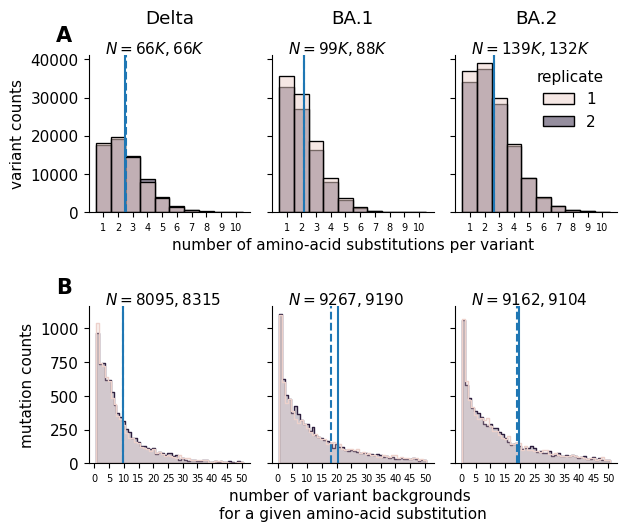

In [55]:
saveas = f"raw_data_summary_barcodes_backgrounds_hist"
logscale=False
fig, ax = plt.subplots(2,3, sharex="row", sharey="row", figsize=[6.4, 5.5])

condition_title = {
    "Delta":"Delta",
    "Omicron_BA1" : "BA.1",
    "Omicron_BA2" : "BA.2"
}

row = 0
for col, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    iter_ax = ax[row, col]
    
    df = condition_df.query("aa_substitutions != ''")
    df = df.assign(
        num_muts = [
            len(aa_subs.split())
            for aa_subs in df.aa_substitutions
        ]
    )
    
    sns.histplot(df.query("num_muts <= 10"), x="num_muts", ax=iter_ax, hue="replicate", discrete=True)
    for rep, rep_df in df.groupby("replicate"):
        mean = rep_df['num_muts'].mean()
        iter_ax.axvline(mean, linestyle=("-" if rep == 1 else "--"))
    
    if logscale: iter_ax.set_yscale('log')
    if col != 2: 
        iter_ax.get_legend().remove()
    n_rep1 = len(df.query("replicate == 1"))//1000
    n_rep2 = len(df.query("replicate == 2"))//1000
    iter_ax.text(
        0.1, 1.1, 
        f"$N={n_rep1}K, {n_rep2}K$", 
        ha="left", va="top", 
        transform=iter_ax.transAxes
    )
    xscale = "number of amino-acid substitutions per variant" if col == 1 else ""
    iter_ax.set_xlabel(xscale)
    
    ylabel = f"variant counts" if col == 0 else ""
    iter_ax.set_ylabel(ylabel)
    iter_ax.set_xticks(
        [i+1 for i in range(10)],
        labels=[i+1 for i in range(10)], 
        ha="center",
        size=7,
        rotation=0
    )
    sns.despine(ax=iter_ax)
    iter_ax.set_title(condition_title[condition], y=1.15)

row = 1
collapsed_bc_df = func_score_df.groupby(
    ["replicate", "condition", "aa_substitutions"]
).aggregate("mean").reset_index()
for col, (condition, condition_df) in enumerate(collapsed_bc_df.groupby("condition")):
    iter_ax = ax[row, col]
    df = pd.DataFrame()
    for rep, rep_df in condition_df.groupby("replicate"):
        
        times_seen = (
            rep_df["aa_substitutions"].str.split().explode().value_counts()
        )
        if (times_seen == times_seen.astype(int)).all():
            times_seen = times_seen.astype(int)
        times_seen = pd.DataFrame(times_seen)
        times_seen.index.name = f"mutation"
        df = pd.concat([df, times_seen.assign(replicate=rep).reset_index()])

    sns.histplot(
        df.query("count <= 50"), 
        x="count", 
        ax=iter_ax, 
        element='step', 
        hue="replicate", 
        discrete=True
    )
    
    for rep, rep_df in df.groupby("replicate"):
        mean = rep_df['count'].mean()
        iter_ax.axvline(mean, linestyle=("-" if rep == 1 else "--"))
        
    iter_ax.get_legend().remove()
    n_rep1 = len(df.query("replicate == 1"))
    n_rep2 = len(df.query("replicate == 2"))
    iter_ax.text(
        0.1, 1.1, 
        f"$N={n_rep1}, {n_rep2}$", 
        ha="left", va="top", 
        transform=iter_ax.transAxes
    )
    
    xscale = "number of variant backgrounds \nfor a given amino-acid substitution" if col == 1 else ""
    iter_ax.set_xlabel(xscale)
    
    ylabel = f"mutation counts" if col == 0 else ""
    iter_ax.set_ylabel(ylabel)
    
    xticks = [i for i in range(0, 51) if i % 5 == 0]
    iter_ax.set_xticks(
        xticks,
        labels=xticks, 
        ha="center",
        size=7,
        rotation=0
    )
    
    sns.despine(ax=iter_ax)

plt.tight_layout()

ax[0,0].text(
    -0.1, 1.06, 
    f"A", 
    ha="right", va="bottom", 
    size=15,
    weight="bold",
    transform=ax[0,0].transAxes
)
ax[1,0].text(
    -0.1, 1.06, 
    f"B", 
    ha="right", va="bottom", 
    size=15,
    weight="bold",
    transform=ax[1,0].transAxes
)

fig.subplots_adjust(hspace=.6)
fig.savefig(f"{OUTDIR}/{saveas}.pdf")
fig.savefig(f"{OUTDIR}/{saveas}.png")
plt.show()

Plot the correlation of variant functional scores (averaged across barcodes) between replicates in each condition, as well as the full distribution of functional scores.

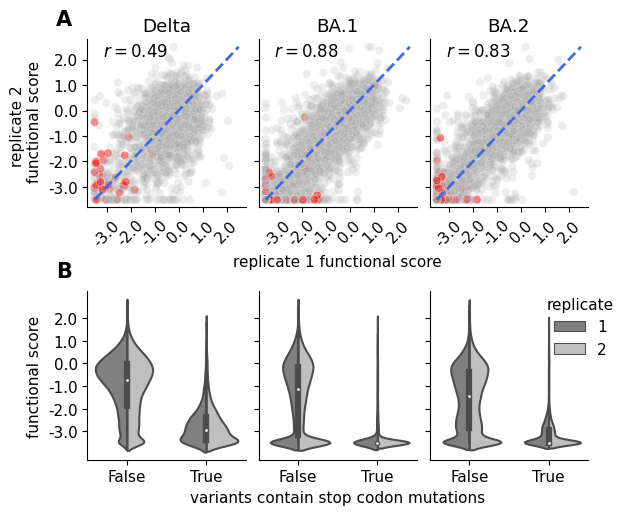

In [56]:
saveas = "replicate_functional_score_correlation_scatter"
pal = sns.color_palette('tab20')

fig, ax = plt.subplots(2,3, sharex="row", sharey="row", figsize=[6.4, 5.3])
collapsed_bc_df = func_score_df.groupby(
    ["replicate", "condition", "aa_substitutions"]
).aggregate("mean").reset_index()
collapsed_bc_df = collapsed_bc_df.assign(
    is_stop=[True if "*" in aasubs else False for aasubs in collapsed_bc_df.aa_substitutions]
)

is_stop_alpha_dict = {
    True : 0.5,
    False : 0.2
}

lim = [-3.8, 2.8]
ticks = np.linspace(-3, 2, 6)
for col, (condition, condition_df) in enumerate(collapsed_bc_df.groupby("condition")):
    
    row = 0
    iter_ax = ax[row, col]
    
    df = reduce(
        lambda left, right: pd.merge(
            left, right, left_index=True, right_index=True, how="inner"
        ),
        [
            rep_df.rename({"func_score":f"rep_{rep}_func_score"}, axis=1).set_index("aa_substitutions")
            for rep, rep_df in condition_df.groupby("replicate") 
        ],
    )
    
    df = df.assign(
        is_stop=[True if "*" in aasubs else False for aasubs in df.index.values]
    )
    df = df.assign(
        n_subs=[len(aasubs.split()) for aasubs in df.index.values]
    )
    
    alpha = [is_stop_alpha_dict[istp] for istp in df.is_stop]
    sns.scatterplot(
        df, 
        x="rep_1_func_score", 
        y="rep_2_func_score", 
        ax =iter_ax,
        alpha=alpha,
        hue="is_stop",
        hue_order=[False, True],
        palette=["darkgrey", "red"]
    )
    
    iter_ax.plot([-3.5, 2.5], [-3.5, 2.5], "--", lw=2, c="royalblue")
    
    iter_ax.set_ylim(lim)
    iter_ax.set_xlim(lim)
    if col == 0:
        iter_ax.set_yticks(ticks, labels=ticks)
    iter_ax.set_xticks(ticks, labels=ticks, rotation=45)
    
    corr = pearsonr(df["rep_1_func_score"], df["rep_2_func_score"])[0]
    iter_ax.annotate(
        f"$r = {corr:.2f}$", 
        (0.1, 0.9), 
        xycoords="axes fraction", 
        fontsize=12
    )
    iter_ax.set_title(condition)
    iter_ax.get_legend().remove()
    sns.despine(ax=iter_ax)
    
    row = 1
    iter_ax = ax[row, col]
    sns.violinplot(
        condition_df,
        x="is_stop",
        y="func_score",
        hue="replicate",
        split=True,
        palette=["0.5", "0.75"],
        ax=iter_ax
    )
    
    sns.despine(ax=iter_ax)
    if col != 2:
        iter_ax.get_legend().remove()
    else:
        iter_ax.legend(bbox_to_anchor = (1.25, 1.05), title="replicate")
    if col == 0:
        iter_ax.set_yticks(ticks, labels=ticks)

ax[0,0].set_xlabel("")
ax[0,0].set_ylabel("replicate 2 \n functional score")

ax[0,1].set_xlabel("replicate 1 functional score")
ax[0,1].set_title("BA.1")
ax[0,2].set_xlabel("")
ax[0,2].set_title("BA.2")

ax[1,0].set_xlabel("")
ax[1,0].set_ylabel("functional score")

ax[1,1].set_xlabel("variants contain stop codon mutations")
ax[1,2].set_xlabel("")
ax[1,2].set_ylabel("")
ax[1,1].set_ylabel("")

ax[0,0].text(
    -0.1, 1.06, 
    f"A", 
    ha="right", va="bottom", 
    size=15,
    weight="bold",
    transform=ax[0,0].transAxes
)
ax[1,0].text(
    -0.1, 1.06, 
    f"B", 
    ha="right", va="bottom", 
    size=15,
    weight="bold",
    transform=ax[1,0].transAxes
)

# fig.suptitle("Variant Functional Score \nReplicate Correlation")
plt.tight_layout()
fig.subplots_adjust(wspace=0.08, hspace = 0.5)
fig.savefig(f"{OUTDIR}/{saveas}.pdf")
fig.savefig(f"{OUTDIR}/{saveas}.png")
plt.show()

## Encode data for fitting

Next, we use the `multidms.Data` class to prep our data for fitting. To see the class docstring describing the required input and keyword arguments, toggle the output for the line below.

In [59]:
help(multidms.Data)

Help on class Data in module multidms.data:

class Data(builtins.object)
 |  Data(variants_df: pandas.core.frame.DataFrame, reference: str, alphabet=('A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'), collapse_identical_variants=False, condition_colors=('#0072B2', '#CC79A7', '#009E73', '#17BECF', '#BCDB22'), letter_suffixed_sites=False, assert_site_integrity=False, verbose=False, nb_workers=None)
 |  
 |  Prep and store one-hot encoding of
 |  variant substitutions data.
 |  Individual objects of this type can be shared
 |  by multiple :py:class:`multidms.Model` Objects
 |  for effeciently fitting various models to the same data.
 |  
 |  Note
 |  ----
 |  You can initialize a :class:`Data` object with a :class:`pandas.DataFrame`
 |  with a row for each variant sampled and annotations
 |  provided in the required columns:
 |  
 |  1. `condition` - Experimental condition from
 |      which a sample measurement was obtained.
 |  2. `aa_su

Instantiate an object for each of our two replicate training sets, and append them to a list 

In [57]:
datasets = []
for res, fsdf in func_score_df.groupby("replicate"):       

    start = time.time()

    # instantiate data object
    data = multidms.Data(
        func_score_df = fsdf,
        collapse_identical_variants="mean",       # take the average variant func score across barcode replicates
        alphabet=multidms.AAS_WITHSTOP_WITHGAP,   # 
        reference="Omicron_BA1",
        assert_site_integrity=False,
        verbose=True,
        nb_workers=8 
    )

    end = time.time()
    prep_time = round(end-start)
    print(f"Finished, time: {prep_time}")

    datasets.append(data)

inferring site map for Delta


  0%|          | 0/28515 [00:00<?, ?it/s]

inferring site map for Omicron_BA1


  0%|          | 0/70597 [00:00<?, ?it/s]

inferring site map for Omicron_BA2


  0%|          | 0/60397 [00:00<?, ?it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [144, 143, 69, 145, 70, 211, 25, 26, 24, 157, 158, 898],
dropping: 10983 variantswhich have mutations at those sites.


invalid non-identical-sites: [371], dropping 2041 variants
Converting mutations for Delta


Converting mutations for Omicron_BA1
is reference, skipping
Converting mutations for Omicron_BA2


Finished, time: 49
inferring site map for Delta


  0%|          | 0/29158 [00:00<?, ?it/s]

inferring site map for Omicron_BA1


  0%|          | 0/62129 [00:00<?, ?it/s]

inferring site map for Omicron_BA2


  0%|          | 0/57719 [00:00<?, ?it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [145, 70, 144, 143, 69, 211, 422, 26, 24, 25, 157, 158],
dropping: 10129 variantswhich have mutations at those sites.


invalid non-identical-sites: [371], dropping 1873 variants
Converting mutations for Delta


Converting mutations for Omicron_BA1
is reference, skipping
Converting mutations for Omicron_BA2


Finished, time: 44


Change the datasets colors - the only mutible thing about `Data` Objects.

In [61]:
# condition colors must be hex-encoded,
palette = [
    '#F97306',
    '#BFBFBF',
    '#9400D3'
]

conditions = [
    "Delta",
    "Omicron_BA1",
    "Omicron_BA2"
]

cc = {con:col for con, col in zip(conditions, palette)}
for data in datasets:
    data.condition_colors = cc

## Fit Models (Shrinkage Analysis)

For each replicate training set, initialize and fit a set models with variable lasso strength coefficients. Here, we use the `multidms.utils.fit_wrapper` function to handle the instatiation, and parameter fitting. Expand the cell output below to view the function docstring.

In [62]:
help(multidms.utils.fit_wrapper)

Help on function fit_wrapper in module multidms.utils:

fit_wrapper(dataset, huber_scale_huber=1, scale_coeff_lasso_shift=2e-05, scale_coeff_ridge_beta=0, scale_coeff_ridge_shift=0, scale_coeff_ridge_gamma=0, scale_coeff_ridge_ch=0, data_idx=0, epistatic_model='Identity', output_activation='Identity', lock_beta=False, lock_beta_naught=None, gamma_corrected=True, alpha_d=False, init_beta_naught=0.0, warmup_beta=False, tol=0.001, num_training_steps=10, iterations_per_step=2000, save_model_at=[2000, 10000, 20000], PRNGKey=0)
    Fit a multidms model to a dataset. This is a wrapper around the multidms
    fit method that allows for easy specification of the fit parameters.
    This method is helpful for comparing and organizing multiple fits.
    
    Parameters
    ----------
    dataset : :class:`multidms.Data`
        The dataset to fit to.
    huber_scale_huber : float, optional
        The scale of the huber loss function. The default is 1.
    scale_coeff_lasso_shift : float, optiona

In [50]:
# all models created will be referenced through this dataframe, tying each model to it's respective hyperparams
models = pd.DataFrame()

# the lasso strength coefficients we will test
shrinkage_sweep = [0.0, 1e-06, 1e-05, 2e-05, 5e-05, 0.0001, 0.0005, 0.001]

# choose fitting hyper-parameters
fit_params = {
    'init_beta_naught' : 0.0,
    'epistatic_model' : "Sigmoid",
    'output_activation' : "Identity",
    'warmup_beta':False,
    'gamma_corrected':False,
    'alpha_d': True,
    'scale_coeff_lasso_shift':lasso,
    'scale_coeff_ridge_beta':0,
    'scale_coeff_ridge_shift':0,
    'scale_coeff_ridge_gamma':1e-3,
    'scale_coeff_ridge_ch':1e-3,
    'tol':1e-4,
    'save_model_at':[30000],
    'num_training_steps': 30,
    'iterations_per_step':1000
}
fit_iter = 0
for lasso in shrinkage_sweep:
    for replicate, dataset in enumerate(datasets):

        # update lasso param
        fit_params['scale_coeff_lasso_shift'] = lasso
        
        start_t = time.time()

        # Create and fit model
        model = multidms.utils.fit_wrapper(dataset, **fit_params)
        model['replicate'] = replicate

        # append model and attributes to the final DataFrame
        models = pd.concat([models, model], ignore_index=True)
        end_t = time.time()
        fit_iter += 1
        print(f"Done with {fit_iter}/{len(shrinkage_sweep)*2}! Total time: {round(end_t - start_t)}")
        print("------------------------------------------")

    # each time we fit both replicates to a lasso, re-write the binary to include the latest models
    pickle.dump(models, open(f"{OUTDIR}/models.pkl", "wb"))

running:
{'PRNGKey': 0,
 'alpha_d': True,
 'data_idx': 0,
 'dataset': <multidms.data.Data object at 0x7fa1c7254290>,
 'epistatic_model': 'Sigmoid',
 'gamma_corrected': False,
 'huber_scale_huber': 1,
 'init_beta_naught': 0.0,
 'iterations_per_step': 1000,
 'lock_beta': False,
 'lock_beta_naught': None,
 'num_training_steps': 30,
 'output_activation': 'Identity',
 'save_model_at': [30000],
 'scale_coeff_lasso_shift': 0.0,
 'scale_coeff_ridge_beta': 0,
 'scale_coeff_ridge_ch': 0.001,
 'scale_coeff_ridge_gamma': 0.001,
 'scale_coeff_ridge_shift': 0,
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 0.0001,
 'warmup_beta': False}
training_step 0/30,Loss: 0.9395107515646628, Time: 23 Seconds
training_step 1/30,Loss: 0.7935431678910877, Time: 17 Seconds
training_step 2/30,Loss: 0.7402912563956504, Time: 17 Seconds
training_step 3/30,Loss: 0.7100134660575739, Time: 17 Seconds
training_s

The cell above saves the models and their relevant hyper-parameters in a `DataFrame` to a `pickle` binary file. Hense, If it's already been run, and you want to execute the code below _without_ re-fitting, the following cell will load that binary file.

In [131]:
models = pickle.load(open(f"{OUTDIR}/models.pkl", "rb"))

We have now fit 8 models per replicate, each with a different lasso strength. These data are organized into a dataframe, where the column "model_30000" contains a reference to the respective `multidms.Model` Object.

In [132]:
models[['epistatic_model', 'output_activation', 'step_loss', 'model_30000', 'replicate']]

epistatic_model output_activation  \
0          Sigmoid          Identity   
1          Sigmoid          Identity   
2          Sigmoid          Identity   
3          Sigmoid          Identity   
4          Sigmoid          Identity   
5          Sigmoid          Identity   
6          Sigmoid          Identity   
7          Sigmoid          Identity   
8          Sigmoid          Identity   
9          Sigmoid          Identity   
10         Sigmoid          Identity   
11         Sigmoid          Identity   
12         Sigmoid          Identity   
13         Sigmoid          Identity   
14         Sigmoid          Identity   
15         Sigmoid          Identity   

                                            step_loss  \
0   [0.9395107515646628, 0.7935431678910877, 0.740...   
1   [0.9531235360436874, 0.7824949636183749, 0.726...   
2   [0.9411085084349053, 0.7951353346883032, 0.738...   
3   [0.9539601906094174, 0.7860932644613358, 0.723...   
4   [0.9529916694713718, 0.8109438266595337, 0.749...   
5   [0.9665988520714643, 0.7995667254358467, 0.733...   
6   [0.9716740948127651, 0.8299453454175213, 0.770...   
7   [0.9829587868024998, 0.8184428455574099, 0.757...   
8   [1.0301489074085346, 0.8814828962596548, 0.831...   
9   [1.0488032403331338, 0.8753436739858613, 0.810...   
10  [1.0710028536597322, 0.9272533240685601, 0.887...   
11  [1.1051185510720019, 0.9214784279548643, 0.877...   
12  [1.260790670167503, 0.9591817432874664, 0.9152...   
13  [1.1129877654379086, 0.9576904772259396, 0.915...   
14  [1.7003381661760741, 0.9936700786708974, 0.914...   
15  [1.067255084146299, 0.9379927931029655, 0.9056...   

                                        model_30000  replicate  
0   <multidms.model.Model object at 0x7fed3020cf10>          0  
1   <multidms.model.Model object at 0x7fed59943c10>          1  
2   <multidms.model.Model object at 0x7fed3020ed90>          0  
3   <multidms.model.Model object at 0x7fed3020fed0>          1  
4   <multidms.model.Model object at 0x7fed30264d50>          0  
5   <multidms.model.Model object at 0x7fed30265990>          1  
6   <multidms.model.Model object at 0x7fed30266f10>          0  
7   <multidms.model.Model object at 0x7fed30268250>          1  
8   <multidms.model.Model object at 0x7fed30269690>          0  
9   <multidms.model.Model object at 0x7fed3026ab10>          1  
10  <multidms.model.Model object at 0x7fed3026c390>          0  
11  <multidms.model.Model object at 0x7fed3026d510>          1  
12  <multidms.model.Model object at 0x7fed3026e410>          0  
13  <multidms.model.Model object at 0x7fed3026f110>          1  
14  <multidms.model.Model object at 0x7fed30274710>          0  
15  <multidms.model.Model object at 0x7fed30275790>          1

In [133]:
# set some global variables
# columns name
model_name = "model_30000"

# the number of times a mutation must be seen in each condition to be included in downstream analysis
times_seen_threshold = 1

# The chosen lasso strength for our final spike model results
chosen_lasso_strength = 5e-5

Plot the model loss over training steps, as provided by `fit_wrapper`.

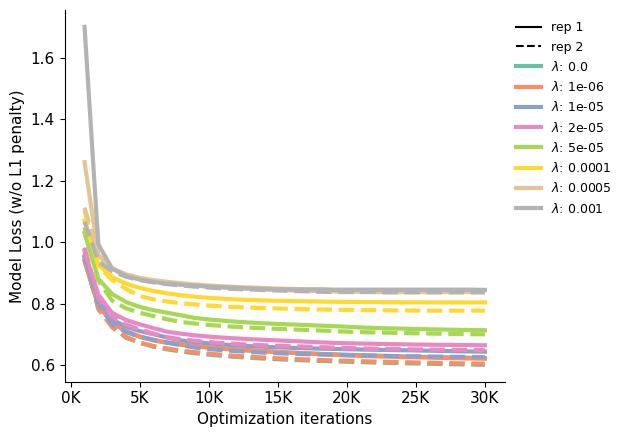

In [134]:
saveas="convergence_all_lasso_lines"
cmap=plt.get_cmap("Set2")


fig, ax = plt.subplots(1,figsize=[6.4,4.5])
color_idx = -1
for i, (model, model_row) in enumerate(models.iterrows()):
    if i%2 == 0: color_idx += 1

    ax.plot(
        [1000 * (s+1) for s in range(len(model_row.step_loss))],
        model_row.step_loss,
        c=cmap.colors[color_idx],
        lw=3,
        linestyle="-" if model_row.replicate == 0 else "--",
        label=f"rep: {model_row.replicate} scale_coeff: {model_row.scale_coeff_lasso_shift}"
    )

ticks = range(0, 30001, 5000)
labels = [f"{t//1000}K" for t in ticks]
ax.set_xticks(ticks, labels, rotation=0, ha='center')
ax.set_ylabel("Model Loss (w/o L1 penalty)")
ax.set_xlabel("Optimization iterations")

black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
lasso_color_handles = [
    mlines.Line2D(
        [], [], 
        color=color, 
        linestyle='-',
        markersize=5,
        linewidth=3,
        label="$\lambda$: "+str(lasso)
    )
    for lasso, color in zip(models.scale_coeff_lasso_shift.unique(), cmap.colors)
]

elements = [black_line, black_dashed] + lasso_color_handles
ax.legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)
sns.despine(ax=ax)
ax.set_ylim()
plt.tight_layout()
fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

Next, we'll wrangle the results of all models into tall-style a dataframe where each row is a single mutation - lasso strength combination

In [135]:
tall_mut_df = pd.DataFrame()
for replicate, rep_models in models.groupby("replicate"):
    fit_dict = {f"l_{float(row.scale_coeff_lasso_shift)}":row[model_name] for _, row in rep_models.iterrows()}
    
    mut_df = multidms.utils.combine_replicate_muts(
        fit_dict, 
        times_seen_threshold=times_seen_threshold, 
        how="outer"
    )
    mut_df.rename(
        {
            bc : f"{bc}_Omicron_BA1"
            for bc in mut_df.columns
            if "beta" in bc
        }, 
        axis=1, 
        inplace=True
    )

    mut_df = pd.melt(
        mut_df.reset_index(), 
        id_vars=["mutation"],
        value_vars=[
            col for col in mut_df.columns 
            if ("_shift_" in col or "beta" in col) and "avg" not in col
        ],
        value_name="S"
    )
    
    mut_df = mut_df.assign(
        scale_coeff_lasso=[ 
            v.split("_")[1]
            for v in mut_df.variable
        ],
        sense=[
            "stop" if "*" in mut else "nonsynonymous"
            for mut in mut_df.mutation
        ],
        condition=[
            "_".join(v.split("_")[3:])
            for v in mut_df.variable
        ],
        replicate=replicate
    )
    
    mut_df.drop("variable", axis=1, inplace=True)
    tall_mut_df = pd.concat([tall_mut_df, mut_df])
    
tall_mut_df.sample(10, random_state=23)

mutation         S scale_coeff_lasso          sense    condition  \
53706     G485D  0.598320               0.0  nonsynonymous        Delta   
58872     I233L -0.972775             1e-06  nonsynonymous        Delta   
109322   K1181N -0.516587               0.0  nonsynonymous  Omicron_BA2   
145884   F1075S  0.000000            0.0005  nonsynonymous  Omicron_BA2   
56057     G842C  0.425078               0.0  nonsynonymous        Delta   
93964     G880C -0.000000            0.0005  nonsynonymous        Delta   
152946    D848Y -0.000000             0.001  nonsynonymous  Omicron_BA2   
7504      Y170- -0.249903             1e-06  nonsynonymous  Omicron_BA1   
109112     F86S -0.741166             1e-06  nonsynonymous  Omicron_BA2   
31092    F1109Y  0.225376             5e-05  nonsynonymous  Omicron_BA1   

        replicate  
53706           0  
58872           0  
109322          1  
145884          0  
56057           1  
93964           0  
152946          1  
7504            1  
109112          0  
31092           0

Compute summary stats of each model at each lasso strength.

In [136]:
def loss(model, condition):
    kwargs = {
        'scale_coeff_ridge_beta': 0.,
        'scale_coeff_ridge_shift': 0.,
        'scale_coeff_ridge_gamma': 0.
    }
    
    data = (
        {condition:model.data.training_data["X"][condition]}, 
        {condition:model.data.training_data["y"][condition]}
    )
    
    params = model.get_condition_params(condition)
    return jax.jit(model._model_components["objective"])(model.params, data)

lasso_sparsity_loss = defaultdict(list)
for lasso, lasso_replicates in models.groupby("scale_coeff_lasso_shift"):
    lasso_sparsity_loss["lasso"].append(str(lasso))
    fit_dict = {}
    for _, row in lasso_replicates.iterrows():
        model = row[model_name]
        replicate = row.replicate
        fit_dict[f"{replicate}"] = model

    muts_df_outer = multidms.utils.combine_replicate_muts(
        fit_dict, 
        times_seen_threshold=times_seen_threshold, 
        how="outer"
    )
    muts_df_outer = muts_df_outer.assign(
        sense = [
            "stop" if "*" in mut else "nonsynonymous"
            for mut in muts_df_outer.index.values
        ]
    )

    muts_df_inner = muts_df_outer.dropna()
    for cond in model.data.conditions:
        if cond == model.data.reference:
            

            if np.all(muts_df_inner[f"0_beta"] <= 0.05) or np.all(muts_df_inner[f"1_beta"] <= 0.05):
                lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(np.nan)
            else:
                corr = pearsonr(muts_df_inner[f"0_beta"], muts_df_inner[f"1_beta"])
                r = corr[0]
                lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(r)

            for rep, marker in zip([0,1], ["o", "D"]):
                rep_cond_shifts = muts_df_outer[[f"{rep}_beta", "sense"]].dropna()
                for sense, color in zip(["stop", "nonsynonymous"], ["red", "blue"]):
                    shifts = rep_cond_shifts.query("sense == @sense")[f"{rep}_beta"]
                    sparsity = (len(shifts[shifts==0]) / len(shifts))*100
                    lasso_sparsity_loss[f"{cond}-{rep}-{sense}-sparsity"].append(sparsity)

        else:
            if np.all(muts_df_inner[f"0_shift_{cond}"] <= 0.05) or np.all(muts_df_inner[f"1_shift_{cond}"] <= 0.05):
                lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(np.nan)
            else:
                corr = pearsonr(muts_df_inner[f"0_shift_{cond}"], muts_df_inner[f"1_shift_{cond}"])
                r = corr[0]
                r = np.nan if np.isclose(r, 1.0) else r
                lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(r)

            for rep, marker in zip([0,1], ["o", "D"]):
                rep_cond_shifts = muts_df_outer[[f"{rep}_shift_{cond}", "sense"]].dropna()
                for sense, color in zip(["stop", "nonsynonymous"], ["red", "blue"]):
                    shifts = rep_cond_shifts.query("sense == @sense")[f"{rep}_shift_{cond}"]
                    sparsity = (len(shifts[shifts==0]) / len(shifts))*100
                    lasso_sparsity_loss[f"{cond}-{rep}-{sense}-sparsity"].append(sparsity)
            
    for _, row in lasso_replicates.iterrows():
        model = row[model_name]
        rep = row.replicate
        for cond in model.data.conditions:
            lasso_sparsity_loss[f"{cond}-{rep}-loss"].append(loss(model, cond))

lasso_sparsity_loss = pd.DataFrame(lasso_sparsity_loss)
lasso_sparsity_loss

lasso  Delta-replicate-correlation  Delta-0-stop-sparsity  \
0     0.0                     0.546623               0.000000   
1   1e-06                     0.559236               1.604278   
2   1e-05                     0.657253              43.850267   
3   2e-05                     0.687851              80.748663   
4   5e-05                     0.697926              97.860963   
5  0.0001                     0.672756             100.000000   
6  0.0005                          NaN             100.000000   
7   0.001                          NaN             100.000000   

   Delta-0-nonsynonymous-sparsity  Delta-1-stop-sparsity  \
0                        0.000000               0.000000   
1                        1.064688               3.791469   
2                       14.566866              44.075829   
3                       25.504114              77.725118   
4                       48.281981              96.682464   
5                       92.030973             100.000000   
6                      100.000000             100.000000   
7                      100.000000             100.000000   

   Delta-1-nonsynonymous-sparsity  Omicron_BA1-replicate-correlation  \
0                        0.000000                           0.927772   
1                        1.153107                           0.928948   
2                       17.120436                           0.929408   
3                       28.219090                           0.924362   
4                       50.416400                           0.914043   
5                       87.363869                           0.913354   
6                      100.000000                           0.910521   
7                      100.000000                           0.908683   

   Omicron_BA1-0-stop-sparsity  Omicron_BA1-0-nonsynonymous-sparsity  \
0                          0.0                                   0.0   
1                          0.0                                   0.0   
2                          0.0                                   0.0   
3                          0.0                                   0.0   
4                          0.0                                   0.0   
5                          0.0                                   0.0   
6                          0.0                                   0.0   
7                          0.0                                   0.0   

   Omicron_BA1-1-stop-sparsity  ...  Omicron_BA2-0-stop-sparsity  \
0                          0.0  ...                     0.000000   
1                          0.0  ...                     3.743316   
2                          0.0  ...                    57.754011   
3                          0.0  ...                    87.700535   
4                          0.0  ...                    99.465241   
5                          0.0  ...                   100.000000   
6                          0.0  ...                   100.000000   
7                          0.0  ...                   100.000000   

   Omicron_BA2-0-nonsynonymous-sparsity  Omicron_BA2-1-stop-sparsity  \
0                              0.000000                     0.000000   
1                              2.274560                     3.317536   
2                             22.471366                    59.715640   
3                             39.425714                    91.943128   
4                             64.462010                    99.526066   
5                             93.950637                   100.000000   
6                             99.983868                   100.000000   
7                            100.000000                   100.000000   

   Omicron_BA2-1-nonsynonymous-sparsity         Delta-0-loss  \
0                              0.000000  0.20909000580973827   
1                              2.274183  0.20917665394134038   
2                             23.398463  0.21720514216870665   
3                             39.509930   0.2246265603265015 

Plot shrinkage figure

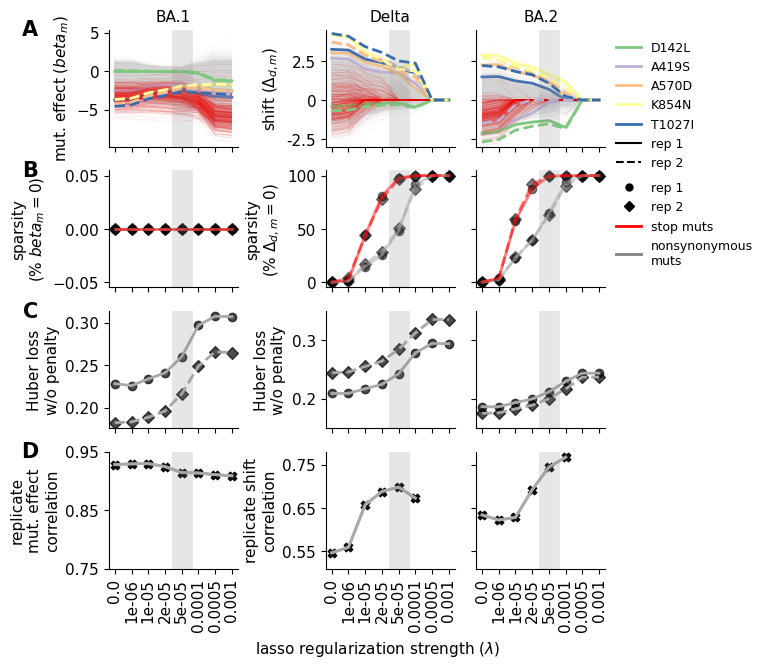

In [137]:
saveas="shrinkage_analysis_trace_plots_beta"
fig, ax = plt.subplots(
    4,4, 
    figsize=[6.4,7],
    sharex=True, 
    gridspec_kw={
        'width_ratios': [1,0.35,1,1]
    }
)

lasso_cmap=plt.get_cmap("Set2").colors
lasso_shrinkage = sorted(models.scale_coeff_lasso_shift.unique())
lasso_shrinkage_cmap = dict(zip(lasso_shrinkage, lasso_cmap))

mutations_to_highlight = ["D142L", "A419S", "A570D", "K854N", "T1027I"]
mutations_cmap=plt.get_cmap("Accent").colors
mutations_cmap = dict(zip(mutations_to_highlight, mutations_cmap))

condition_col = {
    "Omicron_BA1" : 0,
    "Delta" : 2,
    "Omicron_BA2" : 3
}

replicate_line_style = {
    0 : "-",
    1 : "--"
}

replicate_marker = {
    0 : "o",
    1 : "D"
}

sense_colors = {
    "nonsynonymous" : "darkgrey",
    "stop" : "red"
}

sense_lw = {
    "nonsynonymous" : 0.5,
    "stop" : 0.1
}

sense_alpha = {
    "nonsynonymous" : 0.1,
    "stop" : 0.5
}

model_choice = chosen_lasso_strength
model_line_kwargs = {
    "linewidth" : 15,
    "color" : "grey",
    "alpha" : 0.1
}

for (condition, replicate), df in tall_mut_df.groupby(["condition", "replicate"]):
    row = 0
    iter_ax = ax[row, condition_col[condition]]
    sns.despine(ax=iter_ax)
    
    # plot nonsynonymous, non validated
    for mut, trace_df in df.query(
        "sense == 'nonsynonymous' & not mutation.isin(@mutations_to_highlight)"
    ).groupby("mutation"):
        iter_ax.plot(
            trace_df.scale_coeff_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=sense_alpha['nonsynonymous'],
            alpha=sense_alpha['nonsynonymous'],
            color="lightgrey"
        )
    
    # plot stop traces
    for mut, trace_df in df.query("sense == 'stop'").groupby("mutation"):

        iter_ax.plot(
            trace_df.scale_coeff_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=sense_lw['stop'],
            alpha=sense_alpha['stop'],
            color=sense_colors['stop']
        )

    # plot highlighted muts
    for mut, trace_df in df.query(
        "mutation.isin(@mutations_to_highlight)"
    ).groupby("mutation"):
        iter_ax.plot(
            trace_df.scale_coeff_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=2,
            alpha=1.0,
            color=mutations_cmap[mut]
        )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
    
        
    # Plot sparsity    
    row = 1
    iter_ax = ax[row, condition_col[condition]]
    sns.despine(ax=iter_ax)
    
    for sense in ["nonsynonymous", "stop"]:
        iter_ax.plot(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{replicate}-{sense}-sparsity"],
            linestyle=replicate_line_style[replicate],
            linewidth=2,
            alpha=0.5,
            color=sense_colors[sense]
        )
        
        iter_ax.scatter(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{replicate}-{sense}-sparsity"],
            marker=replicate_marker[replicate],
            alpha=0.5,
            color="black"
        )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
        
    # Plot Loss  
    row = 2
    iter_ax = ax[row, condition_col[condition]]
    sns.despine(ax=iter_ax)
    
    
    iter_ax.plot(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-{replicate}-loss"],
        linestyle=replicate_line_style[replicate],
        linewidth=2,
        alpha=1.0,
        color="darkgrey"
    )

    iter_ax.scatter(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-{replicate}-loss"],
        marker=replicate_marker[replicate],
        alpha=0.7,
        color="black"
    )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
    
    # Plot Correlation  
    row = 3
    iter_ax = ax[row, condition_col[condition]]
    sns.despine(ax=iter_ax)
    
    iter_ax.plot(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-replicate-correlation"],
        linestyle="-",
        linewidth=2,
        alpha=1.0,
        color="darkgrey"
    )
    
    iter_ax.scatter(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-replicate-correlation"],
        marker="X",
        alpha=0.7,
        color="black"
    )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)



ax[0, 0].set_title(r"BA.1", size=11)
ax[0, 2].set_title("Delta", size=11)
ax[0, 3].set_title("BA.2", size=11)

ax[0, 1].set_visible(False)
ax[1, 1].set_visible(False)
ax[2, 1].set_visible(False)
ax[3, 1].set_visible(False)

ax[0, 0].set_ylabel("mut. effect ($beta_{m}$)", size=11)
ax[1, 0].set_ylabel("sparsity\n(% $beta_{m} = 0$)", size=11)
# ax[2, 0].set_ylabel("condition\n train data loss \n$L_{Huber_{\sigma=1}}^{d}$ w/o penalty", size=11)
# ax[2, 0].set_ylabel("condition\n training data loss", size=11)
ax[2, 0].set_ylabel("Huber loss\nw/o penalty", size=11)
# ax[3, 0].set_ylabel("$r(beta_{m}^{rep1},beta_{m}^{rep2})$", size=11)
ax[3, 0].set_ylabel("replicate\nmut. effect\ncorrelation", size=11)

ax[0, 2].set_ylabel("shift $(\Delta_{d,m})$", size=11)
ax[1, 2].set_ylabel("sparsity\n(% $\Delta_{d,m} = 0$)", size=11)
# ax[2, 2].set_ylabel("Huber loss\n w/o penalty", size=11)
ax[2, 2].set_ylabel("Huber loss\nw/o penalty", size=11)
# ax[2, 0].set_ylabel("condition\n training data loss", size=11)

# ax[3, 2].set_ylabel("$r(\Delta_{d,m}^{rep1},\Delta_{d,m}^{rep2})$", size=11)
ax[3, 2].set_ylabel("replicate shift\ncorrelation", size=11)

# TODO legends
black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
lasso_color_handles = [
    mlines.Line2D(
        [], [], 
        color=color, 
        linestyle='-',
        markersize=2,
        linewidth=2,
        label=mut
    )
    for mut, color in mutations_cmap.items()
]

elements = lasso_color_handles + [black_line, black_dashed] 
ax[0,3].legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)

black_circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=5, label='rep 1')
black_triangle = mlines.Line2D([], [], color='black', marker='D', linestyle='None',
                          markersize=5, label='rep 2')

red_line = mlines.Line2D([], [], color='red', linewidth=2,linestyle='-',markersize=5, label='stop muts')
grey_line = mlines.Line2D([], [], color='grey',linewidth=2, linestyle='-',markersize=5, label='nonsynonymous\nmuts')

elements = [black_circle, black_triangle, red_line, grey_line] #+lasso_color_handles
ax[1, 3].legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)

ax[3,0].set_xticks(ax[3,0].get_xticks(), ax[3,0].get_xticklabels(), rotation=90, ha='center')
ax[3,2].set_xticks(ax[3,2].get_xticks(), ax[3,2].get_xticklabels(), rotation=90, ha='center')
ax[3,3].set_xticks(ax[3,3].get_xticks(), ax[3,3].get_xticklabels(), rotation=90, ha='center')

ax[3,2].set_xlabel(f"lasso regularization strength ($\lambda$)")
ax[3,2].xaxis.set_label_coords(0.4, -0.6)

ax[0,0].text(
    -0.55, 1.00, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[0,0].transAxes
)
ax[1,0].text(
    -0.55, 1.00, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[1,0].transAxes
)
ax[2,0].text(
    -0.55, 1.00, 
    f"C", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[2,0].transAxes
)
ax[3,0].text(
    -0.55, 1.00, 
    f"D", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[3,0].transAxes
)

ax[0, 2].set_yticks([-2.5, 0, 2.5], [-2.5, 0, 2.5])
ax[0, 2].set_ylim([-3.0, 4.5])
ax[0, 3].set_yticks([-2.5, 0, 2.5], [-2.5, 0, 2.5])
ax[0, 3].set_ylim([-3.0, 4.5])
ax[0, 3].yaxis.set_tick_params(labelleft=False)

ax[1, 2].set_yticks([0, 50, 100], [0, 50, 100])
ax[1, 2].set_ylim([-5, 105])
ax[1, 3].set_yticks([0, 50, 100], [0, 50, 100])
ax[1, 3].set_ylim([-5, 105])
ax[1, 3].yaxis.set_tick_params(labelleft=False)

ax[2, 2].set_yticks([.1, .2, .3], [.1, .2, .3])
ax[2, 2].set_ylim([.15, .35])
ax[2, 3].set_yticks([.1, .2, .3], [.1, .2, .3])
ax[2, 3].set_ylim([.15, .35])
ax[2, 3].yaxis.set_tick_params(labelleft=False)

ax[3, 2].set_yticks([.55, .65, .75], [.55, .65, .75])
ax[3, 2].set_ylim([.51, .78])
ax[3, 3].set_yticks([.55, .65, .75], [.55, .65, .75])
ax[3, 3].set_ylim([.51, .78])
ax[3, 3].yaxis.set_tick_params(labelleft=False)

ax[3, 0].set_yticks([.75, .85, .95], [.75, .85, .95])

# plt.tight_layout()
fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Global epistasis fits

Here, we take a look at the fit of the sigmoidal global epistasis function (at the chosen lasso coefficient of 5e-5) to the data.

For each replicate at the chosen lasso strength, we get the training data predictions using `model.get_variants_df`, and use `model.get_condition_params` paried with `model.model_components` for visualizing the global epistasis function with the current model parameters. See the function docs strings for the relevant details of each.

In [138]:
chosen_replicate_models = models.query("scale_coeff_lasso_shift == @chosen_lasso_strength")
replicate_data = {}
for row_idx, replicate_row in chosen_replicate_models.iterrows():
    model = replicate_row[model_name]

    # get training data variants and their respective 
    df = model.get_variants_df(phenotype_as_effect=False)

    # find the low/high bound of the training data and use those to make
    # global epistasis predictions across the range for plotting
    xlb, xub = [-1, 1] + np.quantile(df.predicted_latent, [0.05, 1.0])
    additive_model_grid = np.linspace(xlb, xub, num=1000)

    # make predictions on hypothetical data points between lower, and upper bound
    current_params = model.get_condition_params(model.data.reference)
    latent_preds = model.model_components["g"](current_params["theta"], additive_model_grid)
    shape = (additive_model_grid, latent_preds)   

    # save and organize the data for plotting
    replicate_data[replicate_row.replicate] = {
        "variants_df" : df,
        "wildtype_df" : model.wildtype_df,
        "epistasis_shape" : shape,
        "condition_colors" : model.data.condition_colors
    }

Plot the observed functional scores of a random sample of all variants (20%), as function of both latent phenotype prediction (top), and functional score phenotype prediction (bottom).

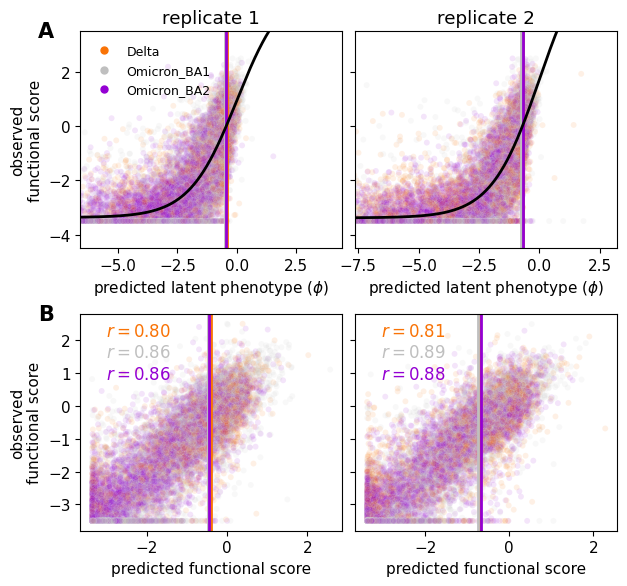

In [139]:
saveas="global_epistasis_and_prediction_correlations"
fig, ax = plt.subplots(2,2, figsize=[6.4,6], sharey='row')    

row=0
for replicate, data in replicate_data.items():

    iter_ax = ax[row, replicate]
    sns.scatterplot(
        data=data["variants_df"].sample(frac=0.2),
        x="predicted_latent",
        y=f"func_score",
        hue="condition",
        palette=model.data.condition_colors,
        ax=iter_ax,
        legend=False,
        size=5,
        alpha=0.1,
        lw=3
    )
    
    for condition, values in data["wildtype_df"].iterrows():
        iter_ax.axvline(
            values.predicted_latent,
            label=condition,
            c=model.data.condition_colors[condition],
            lw=2,
        )
    
    iter_ax.plot(*data["epistasis_shape"], color="k", lw=2)
    
    xlb, xub = [-1, 1] + np.quantile(data["variants_df"].predicted_latent, [0.05, 1.0])
    ylb, yub = [-1, 1] + np.quantile(data["variants_df"].func_score, [0.05, 1.0])
    iter_ax.set_xlim([xlb, xub])
    iter_ax.set_ylim([ylb, yub])
    iter_ax.set_title(f"replicate {replicate+1}")
    iter_ax.set_ylabel("observed\nfunctional score")
    iter_ax.set_xlabel("predicted latent phenotype ($\phi$)")

row=1
for replicate, data in replicate_data.items():

    iter_ax = ax[row, replicate]
    sns.scatterplot(
        data=data["variants_df"].sample(frac=0.1),
        x="predicted_func_score",
        y=f"func_score",
        hue="condition",
        palette=model.data.condition_colors,
        ax=iter_ax,
        legend=False,
        size=5,
        alpha=0.1
    )
    
    for condition, values in data["wildtype_df"].iterrows():
        iter_ax.axvline(
            values.predicted_latent,
            label=condition,
            c=model.data.condition_colors[condition],
            lw=2,
        )
    
    iter_ax.set_ylabel("observed\nfunctional score")
    iter_ax.set_xlabel("predicted functional score")

    start_y = 0.9
    for c, cdf in data["variants_df"].groupby("condition"):
        r = pearsonr(
            cdf["predicted_func_score"],
            cdf["func_score"]
        )[0]
        iter_ax.annotate(
            f"$r = {r:.2f}$",
            (0.1, start_y),
            xycoords="axes fraction",
            fontsize=12,
            c=model.data.condition_colors[c],
        )
        start_y += -0.1


elements = [
    mlines.Line2D([], [], color=color, marker='o', linestyle='None',markersize=5, label=condition)
    for condition, color in replicate_data[0]["condition_colors"].items()
]


ax[0, 0].legend(
    handles=elements, 
    bbox_to_anchor = (0., .99), 
    loc='upper left', 
    frameon=False, 
    fontsize=9
)
    
    
plt.tight_layout()
fig.subplots_adjust(wspace=0.05)

ax[0,0].text(
    -0.1, 1.00, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[0,0].transAxes
)
ax[1,0].text(
    -0.1, 1.00, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[1,0].transAxes
)


fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Shifted mutations (interactive altair chart)

The easiest way to view shifted mutations is to create an interactive `altair` chart using `multidms.plot.mut_shift_plot`. This function can take a single model, or a collection of models in a dictionary if you want to visualize the aggregated (mean) results of shared mutations between models. Toggle the drop down for the cell below to see details on using this function. 

In [140]:
help(multidms.plot.mut_shift_plot)

Help on function mut_shift_plot in module multidms.plot:

mut_shift_plot(fit_data, biochem_order_aas=True, times_seen_threshold=3, include_beta=True, **kwargs)
    Make plot of mutation escape values for one or more replicate fits.
    You may either pass a single `multidms.Data` object for
    visualizing a single set of parameters or a collection of replicate
    fits in the form of a dictionary where key's are the replicate
    name (i.e. rep1, rep2) and values are the respective model objects.
    
    Parameters
    ----------
    fit_data : multidms.Data or dict
        Either a single `multidms.Data` object or a dictionary of
        replicate fits where the keys are the replicate names and the values
        are the respective model objects.
    biochem_order_aas : bool
        Biochemically order amino-acid alphabet :attr:`PolyclonalCollection.alphabet`
        by passing it through :func:`polyclonal.alphabets.biochem_order_aas`.
    times_seen_threshold : int
        Set a th

Here, we create the interactive chart by feeding the function a dictionary containing the two replicate models, and specifying:

1. times_seen_threshold = 1, meaning for a mutation to be included, it must be seen at least once in every condition
2. inlcude_beta = False, we only wish to see the shifted parameters visualized, not the respective _effect_ (beta) parameters. (note that respective effect values will be added as a tooltip when hovering over any shift mutation).

To view the chart, toggle the output of the cell below.

In [141]:
chart = multidms.plot.mut_shift_plot(
    {
        f"rep_{row.replicate}":row[model_name] 
        for idx, row in chosen_replicate_models.iterrows()
    },
    include_beta = False,
    times_seen_threshold=1
)
chart.save(f"{OUTDIR}/interactive_chart_wo_beta.html")
chart

alt.VConcatChart(...)

## Shifted mutations (manually queried)

While the interactive chart is a nice quick view of the shift parameters, one may instead wish to query the mutation parameters directly. While all individual mutation parameters for any given model are accessible via the `Model.get_mutations_df` method, `multidms.utils.combine_replicate_muts` provides a way to easily combine data from multiple models. For example, the cell below inner-merges the mutations dataframes from each of the replicates, and returns a single dataframe to summarize the indivual replicate parameters, as well as the average between the models. The output shows a subset of the resulting dataframe as an example.

In [142]:
# could add a 'min' column of 0, and 1
chosen_replicate_models = models.query("scale_coeff_lasso_shift == @chosen_lasso_strength")
mut_df_replicates = multidms.utils.combine_replicate_muts(
    {
        row.replicate:row[model_name] for idx, row in chosen_replicate_models.iterrows()
    },
    times_seen_threshold=times_seen_threshold,
    how="inner"
)
mut_df_replicates.to_csv(f"{OUTDIR}/mutations_df.csv")
mut_df_replicates[["0_beta", "1_beta", "avg_beta", "0_shift_Delta", "1_shift_Delta", "avg_shift_Delta"]].sample(10, random_state=23)

0_beta    1_beta  avg_beta  0_shift_Delta  1_shift_Delta  \
mutation                                                               
G482S    -0.339788 -0.569853 -0.454820       0.152494       0.426878   
G769R    -0.195456 -0.214381 -0.204918      -0.000000       0.124869   
T307P    -3.341723 -5.070430 -4.206076       0.000000       0.000000   
S673R     0.188700  0.133538  0.161119      -0.000000      -0.203490   
A653S    -2.630253 -7.092575 -4.861414       0.230924       0.000000   
G476D    -0.466555 -0.378945 -0.422750       0.277673       0.264300   
V1065A   -0.231540 -0.255227 -0.243383       0.109368       0.125877   
G838R    -0.073420 -0.128242 -0.100831      -0.318640       0.000000   
M902I    -1.992020 -2.799488 -2.395754       1.379572       2.514609   
K786E    -0.190493 -0.118602 -0.154547      -0.000000       0.000000   

          avg_shift_Delta  
mutation                   
G482S            0.289686  
G769R            0.062434  
T307P            0.000000  
S673R           -0.101745  
A653S            0.115462  
G476D            0.270986  
V1065A           0.117623  
G838R           -0.159320  
M902I            1.947090  
K786E            0.000000

We need the sitemap of inferred wildtype amino acids at each site, for each condition. This is easily accessible via the `Model.data` attribute 

In [99]:
site_map = model.data.site_map
site_map.loc[10:20, :]

Delta Omicron_BA1 Omicron_BA2
10     L           L           L
11     V           V           V
12     S           S           S
13     S           S           S
14     Q           Q           Q
15     C           C           C
16     V           V           V
17     N           N           N
18     L           L           L
19     R           T           I
20     T           T           T

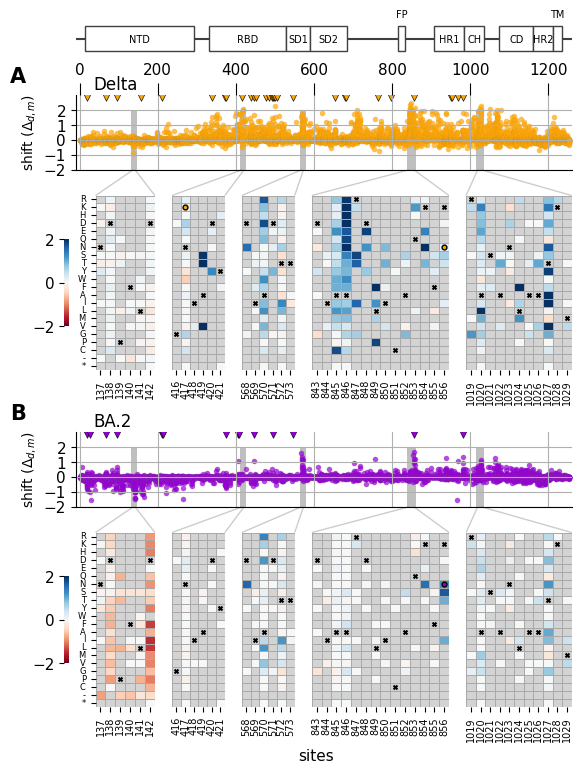

In [100]:
# some renaming and wrangling
mut_df_replicates["sense"] = ["stop" if mut == "*" else "nonsynonymous" for mut in mut_df_replicates.muts]
rename_omicron = {
    c:"_".join(c.split("_")[:2]+[c.split("_")[3]])
    for c in mut_df_replicates.columns if "Omicron" in c
}
mut_df_replicates.rename(rename_omicron, axis=1, inplace=True)
site_map = site_map.reset_index().rename(
    {"index":"sites", "Omicron_BA2": "BA2", "Omicron_BA1":"BA1"}, axis=1
).set_index("sites")

saveas = "shift_by_site_heatmap_zoom"

site_ranges = {
    "zoom1" : [137, 142],
    "zoom2" : [416, 421],
    "zoom3" : [568, 573],
    "zoom4" : [843, 856],
    "zoom5" : [1019, 1029]
}

# heatmap ax width ratios
width_ratios = [(end-start) for key, (start, end) in site_ranges.items()]

# make the first one a little bigger for the color bar
width_ratios[0] += width_ratios[0] * 0.5


# Plot domain architecture in primary sequence
# based on structure papers (Gobeil et al., 2022, Molecular Cell)
# (Duan et al., 2020, Frotiers in Immunology)
domain_dict = {
    'NTD' : [13, 293],
    'RBD' : [330, 528],
    'SD1' : [528, 590],
    'SD2' : [590, 685],
    'FP' : [815, 834],
    'HR1' : [907, 985],
    'CH' : [985, 1035],
    'CD' : [1075, 1162],
    'HR2' : [1162, 1211],
    'TM' : [1211, 1234],
}

sort_order = [
    "R","K","H","D","E","Q","N","S",
    "T","Y","W","F","A","I","L","M",
    "V","G","P","C","-","*",
]

fig = plt.figure( figsize=[6.4, 9])
axs = fig.subplot_mosaic(
    [
        ["Annotation"]*5,
        ["Delta"]*5,
        [f"{k}_Delta" for k in list(site_ranges.keys())],
        [f"{k}_Delta" for k in list(site_ranges.keys())],
        ["."]*5,
        ["BA2"]*5,
        [f"{k}_BA2" for k in list(site_ranges.keys())],
        [f"{k}_BA2" for k in list(site_ranges.keys())]
    ],
    
    height_ratios=[
        1.5, 
        2, 
        2, 
        2,
        0.3,
        2,
        2, 
        2
    ],
    empty_sentinel=".",
    # set the width ratios between the columns
    width_ratios=width_ratios,
    gridspec_kw={
        "wspace": 0.20,
        "hspace": 0.4,
    }
)

# derived from
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/axes_zoom_effect.html
def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = {
            **prop_lines,
            "alpha": prop_lines.get("alpha", 1) * 0.2,
            "clip_on": False,
        }

    c1 = BboxConnector(
        bbox1, bbox2, loc1=loc1a, loc2=loc2a, clip_on=False, **prop_lines)
    c2 = BboxConnector(
        bbox1, bbox2, loc1=loc1b, loc2=loc2b, clip_on=False, **prop_lines)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(bbox1, bbox2,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           clip_on=False,
                           **prop_patches)

    return c1, c2, bbox_patch1, bbox_patch2, p

def zoom_effect03(ax1, ax2, xmin, xmax, **kwargs):

    mybbox1 = ax1.bbox
    
    bbox = Bbox.from_extents(xmin, 0, xmax, 1)
    mybbox2 = TransformedBbox(bbox, ax2.get_xaxis_transform())

    prop_patches = {**kwargs, "ec": "none", "alpha": 0.2}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2,
        loc1a=2, loc2a=3, loc1b=1, loc2b=4,
        prop_lines=kwargs, prop_patches=prop_patches)

    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

#############
# sitewise
#############


pal = sns.color_palette('colorblind')
cs = ['darkviolet', 'orange']
cs = {
    'BA2' : 'darkviolet', 
    'Delta' : 'orange'
}

# Plot per-site metric
metric_prefix = 'max_abs_shift_'
for (i, homolog) in enumerate(['BA2', 'Delta']):

    sns.scatterplot(
        x='sites', 
        y=f'avg_shift_{homolog}',
        data=mut_df_replicates, 
        s=15,
        alpha=0.7,
        edgecolor="grey",
        linewidth=0.05,
        ax=axs[homolog], 
        color=cs[homolog],
        label=""
    )
    
    nis = site_map.query(f"{homolog} != BA1")
    sns.scatterplot(
        x='sites', 
        y=np.repeat(2.9, len(nis)),
        data=nis, 
        s=30,
        ax=axs[homolog],
        marker='v',
        facecolor=cs[homolog], 
        edgecolor="k"
    )

    axs[homolog].grid()
    axs[homolog].set(
        xlim=[-10,1260],
        ylim=[-2, 3],
        yticks=[-2, -1, 0, 1, 2],
    )
    sns.despine(ax=axs[homolog])
    
    axs[homolog].tick_params(
        axis='x', 
        bottom=False,
        labelbottom=False,
        labeltop=True if homolog == "Delta" else False,
        top=True if homolog == "Delta" else False,
        size=9
    )
    axs[homolog].set_xlabel(None)
    axs[homolog].set_ylabel('shift ($\Delta_{d,m}$)', size=10)


axs["BA2"]._shared_axes['x'].join(axs["BA2"], axs["Delta"])

plot_rectangles = True
for zoom, site_range in site_ranges.items():
    if not plot_rectangles:
        continue
    (site_i, site_j) = site_range
    for (i, homolog) in enumerate(['BA2', 'Delta']):
        rect = patches.Rectangle(
            (site_i-5, -2), site_j-site_i+11, 4,
            edgecolor='none', facecolor='0.75', zorder=0
        )
        axs[homolog].add_patch(rect)
        
        
#############
# Annotation
#############

for (domain, (start, end)) in domain_dict.items():
    rectangle = patches.Rectangle((start, 1), end-start, 2, edgecolor='0.25', facecolor='white')
    axs["Annotation"].add_patch(rectangle)
    rx, ry = rectangle.get_xy()
    cx = rx + rectangle.get_width()/2.0
    cy = ry - 0.05 + rectangle.get_height()/2.0
    if domain in ['FP', 'TM']:
        cy += 2
    axs["Annotation"].annotate(
        domain, (cx, cy), color='black', ha='center', va='center',
        fontsize=7
    )

axs["Annotation"].set(ylim=[-0.5,4], yticks=[])
sns.despine(left=True, bottom=True, ax=axs["Annotation"])

axs["Annotation"].sharex(axs["BA2"])
axs["Annotation"].axhline(2, c='0.25', zorder=0)
axs["Annotation"].xaxis.set_tick_params(which='both', bottom=False, labelbottom=False, labeltop=False)

#############
# Heatmap
#############

for (i, homolog) in enumerate(['Delta', 'BA2']):
    
    df_shifts_wide = mut_df_replicates.pivot(
        index='muts', 
        columns='sites', 
        values=f'avg_shift_{homolog}'
    ).loc[sort_order, :]

    for zoom, (start, end) in site_ranges.items():
        
        iter_ax = axs[f"{zoom}_{homolog}"]
        iter_ax.set_facecolor("lightgrey")
        sites = [s for s in list(range(start, end+1)) if s in df_shifts_wide.columns]
        
        sns.heatmap(
            df_shifts_wide.loc[:, sites], 
            cbar=True if zoom == "zoom1" else False,
            cbar_kws={
                "shrink": 0.5, 
                "location":'left',
                'anchor': (-1.5, 0.5),
                'label' : None
            },
            ax = iter_ax,
            linewidth=.5, 
            linecolor="darkgrey",
            center=0,
            cmap='RdBu',
            vmin=-2.0,
            vmax=2.0,
            xticklabels=False,
            yticklabels=False,
        )

        for i, site in enumerate(sites):
            for j, mut in enumerate(sort_order):
                
                is_ref_wt = True if mut == site_map.loc[site,"BA1"] else False
                if is_ref_wt:
                    iter_ax.scatter(
                        [i+0.5], 
                        [j+0.5], 
                        marker="x", 
                        s=8, 
                        c="black"
                    )
#                 hom = homolog if homolog == "Delta" else "Omicron_BA2"
                is_nis = (
                    True 
                    if mut ==  site_map.loc[site,homolog] and
                    mut !=  site_map.loc[site,"BA1"]
                    else False
                )
                
                if is_nis:
                    iter_ax.scatter(
                        [i+0.5], 
                        [j+0.5], 
                        marker="o", 
                        s=12, 
                        facecolors=cs[homolog],
                        edgecolors="black"
                    )

        if zoom != "zoom1":
            axs[f"{zoom}_{homolog}"].tick_params(axis='y', left=False, labelleft=False)
            sns.despine(left=True, bottom=True, ax=axs[f"{zoom}_{homolog}"])  
        else:
            axs[f"{zoom}_{homolog}"].set_yticks(
                [s+0.5 for s in range(len(sort_order))],
                labels=sort_order, 
                va="center",
                size=6
            )
            
        axs[f"{zoom}_{homolog}"].set_ylabel(None)
            
        if homolog != "Delta":
#             axs[f"{zoom}_{homolog}"].tick_params(axis='x', bottom=False, labelbottom=False) 
#         else:
            axs[f"{zoom}_{homolog}"].sharex(axs[f"{zoom}_Delta"])
        axs[f"{zoom}_{homolog}"].set_xticks(
            [s+0.5 for s in range(len(sites))],
             labels=sites, 
             ha="center",
            rotation=90,
            size=7
        )
        axs[f"{zoom}_{homolog}"].set_xlabel(None)

for zoom, (start, end) in site_ranges.items():
    for homolog in ['Delta', 'BA2']:
        zoom_effect03(axs[f"{zoom}_{homolog}"], axs[homolog], start, end, alpha= 0.2)

fig.text(
    0.5, 0.05, 'sites',
    ha='center'
)

axs["Delta"].text(
    -0.1, 1.25, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["Delta"].transAxes
)
axs["Delta"].text(
    0.035, 1.15, 
    f"Delta", 
    ha="left", va="center", 
    size=12,
    transform=axs["Delta"].transAxes
)

axs["BA2"].text(
    -0.1, 1.25, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["BA2"].transAxes
)
axs["BA2"].text(
    0.035, 1.15, 
    f"BA.2", 
    ha="left", va="center", 
    size=12,
    transform=axs["BA2"].transAxes
)

fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Comparison of results to the naive approach (independent-condition fits)

here we fit a model to each homolog individually, so that we may compare the results to our joint fitting process

In [104]:
naive_models = pd.DataFrame()
fit_params = {
    'init_beta_naught' : 0.0,
    'epistatic_model' : "Sigmoid",
    'output_activation' : "Identity",
    'warmup_beta':False,
    'gamma_corrected':False,
    'alpha_d':False, # no non-reference conditions for which these apply
    'scale_coeff_ridge_beta':0,
    'scale_coeff_ridge_shift':0,
    'tol':1e-6,
    'save_model_at':[3000], # single condition fits (with no shift params) converge much faster
    'num_training_steps': 3,
    'iterations_per_step':1000
}

for (replicate, condition), condition_fsdf in func_score_df.groupby(["replicate", "condition"]):
    start = time.time()
    data = multidms.Data(
        condition_fsdf,
        collapse_identical_variants="mean",
        alphabet=multidms.AAS_WITHSTOP_WITHGAP,
        reference=condition,
        assert_site_integrity=False,
        verbose=True,
        nb_workers=8 
    )
    data.condition_colors = cc        
    
    end = time.time()
    prep_time = round(end-start)
    print(f"Finished, time: {prep_time}")
    
    start_t = time.time()
    model = multidms.utils.fit_wrapper(data, **fit_params)
    model['replicate'] = replicate-1 # TODO fix this in all fits i.e. make sure we refer to 1-indexed replicate ID
    model['condition'] = condition
    
    naive_models = pd.concat([naive_models, model], ignore_index=True)
    end_t = time.time()
    print(f"Done! Total time: {round(end_t - start_t)}")
    print("------------------------------------------")
    
    pickle.dump(naive_models, open(f"{OUTDIR}/naive_models.pkl", "wb"))

inferring site map for Delta


  0%|          | 0/28515 [00:00<?, ?it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.


invalid non-identical-sites: [], dropping 0 variants
Converting mutations for Delta
is reference, skipping
Finished, time: 7
running:
{'PRNGKey': 0,
 'alpha_d': False,
 'data_idx': 0,
 'dataset': <multidms.data.Data object at 0x7fdd6d183410>,
 'epistatic_model': 'Sigmoid',
 'gamma_corrected': False,
 'huber_scale_huber': 1,
 'init_beta_naught': 0.0,
 'iterations_per_step': 1000,
 'lock_beta': False,
 'lock_beta_naught': None,
 'num_training_steps': 3,
 'output_activation': 'Identity',
 'save_model_at': [3000],
 'scale_coeff_lasso_shift': 2e-05,
 'scale_coeff_ridge_beta': 0,
 'scale_coeff_ridge_ch': 0,
 'scale_coeff_ridge_gamma': 0,
 'scale_coeff_ridge_shift': 0,
 'step_loss': array([0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': False}
training_step 0/3,Loss: 0.31203029678950267, Time: 8 Seconds
training_step 1/3,Loss: 0.23625210580935843, Time: 4 Seconds
training_step 2/3,Loss: 0.2177170512535205, Time: 4 Seconds
Done! Total time: 18
------------------------------------------
inferring 

  0%|          | 0/70597 [00:00<?, ?it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.


invalid non-identical-sites: [], dropping 0 variants
Converting mutations for Omicron_BA1
is reference, skipping
Finished, time: 12
running:
{'PRNGKey': 0,
 'alpha_d': False,
 'data_idx': 0,
 'dataset': <multidms.data.Data object at 0x7fdd6def34d0>,
 'epistatic_model': 'Sigmoid',
 'gamma_corrected': False,
 'huber_scale_huber': 1,
 'init_beta_naught': 0.0,
 'iterations_per_step': 1000,
 'lock_beta': False,
 'lock_beta_naught': None,
 'num_training_steps': 3,
 'output_activation': 'Identity',
 'save_model_at': [3000],
 'scale_coeff_lasso_shift': 2e-05,
 'scale_coeff_ridge_beta': 0,
 'scale_coeff_ridge_ch': 0,
 'scale_coeff_ridge_gamma': 0,
 'scale_coeff_ridge_shift': 0,
 'step_loss': array([0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': False}
training_step 0/3,Loss: 0.24738580498232585, Time: 8 Seconds
training_step 1/3,Loss: 0.22392991691351716, Time: 5 Seconds
training_step 2/3,Loss: 0.2188506098576127, Time: 5 Seconds
Done! Total time: 19
------------------------------------------
inf

  0%|          | 0/60397 [00:00<?, ?it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.


invalid non-identical-sites: [], dropping 0 variants
Converting mutations for Omicron_BA2
is reference, skipping
Finished, time: 11
running:
{'PRNGKey': 0,
 'alpha_d': False,
 'data_idx': 0,
 'dataset': <multidms.data.Data object at 0x7fef6923c1d0>,
 'epistatic_model': 'Sigmoid',
 'gamma_corrected': False,
 'huber_scale_huber': 1,
 'init_beta_naught': 0.0,
 'iterations_per_step': 1000,
 'lock_beta': False,
 'lock_beta_naught': None,
 'num_training_steps': 3,
 'output_activation': 'Identity',
 'save_model_at': [3000],
 'scale_coeff_lasso_shift': 2e-05,
 'scale_coeff_ridge_beta': 0,
 'scale_coeff_ridge_ch': 0,
 'scale_coeff_ridge_gamma': 0,
 'scale_coeff_ridge_shift': 0,
 'step_loss': array([0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': False}
training_step 0/3,Loss: 0.215951267970427, Time: 8 Seconds
training_step 1/3,Loss: 0.19288537791487256, Time: 5 Seconds
training_step 2/3,Loss: 0.1881276456144402, Time: 5 Seconds
Done! Total time: 19
------------------------------------------
infer

  0%|          | 0/29158 [00:00<?, ?it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.


invalid non-identical-sites: [], dropping 0 variants
Converting mutations for Delta
is reference, skipping
Finished, time: 7
running:
{'PRNGKey': 0,
 'alpha_d': False,
 'data_idx': 0,
 'dataset': <multidms.data.Data object at 0x7fef6b256750>,
 'epistatic_model': 'Sigmoid',
 'gamma_corrected': False,
 'huber_scale_huber': 1,
 'init_beta_naught': 0.0,
 'iterations_per_step': 1000,
 'lock_beta': False,
 'lock_beta_naught': None,
 'num_training_steps': 3,
 'output_activation': 'Identity',
 'save_model_at': [3000],
 'scale_coeff_lasso_shift': 2e-05,
 'scale_coeff_ridge_beta': 0,
 'scale_coeff_ridge_ch': 0,
 'scale_coeff_ridge_gamma': 0,
 'scale_coeff_ridge_shift': 0,
 'step_loss': array([0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': False}
training_step 0/3,Loss: 0.29486979266750474, Time: 7 Seconds
training_step 1/3,Loss: 0.25160339956684524, Time: 4 Seconds
training_step 2/3,Loss: 0.24226085800695712, Time: 4 Seconds
Done! Total time: 17
------------------------------------------
inferring

  0%|          | 0/62129 [00:00<?, ?it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.


invalid non-identical-sites: [], dropping 0 variants
Converting mutations for Omicron_BA1
is reference, skipping
Finished, time: 12
running:
{'PRNGKey': 0,
 'alpha_d': False,
 'data_idx': 0,
 'dataset': <multidms.data.Data object at 0x7fef6ae56f90>,
 'epistatic_model': 'Sigmoid',
 'gamma_corrected': False,
 'huber_scale_huber': 1,
 'init_beta_naught': 0.0,
 'iterations_per_step': 1000,
 'lock_beta': False,
 'lock_beta_naught': None,
 'num_training_steps': 3,
 'output_activation': 'Identity',
 'save_model_at': [3000],
 'scale_coeff_lasso_shift': 2e-05,
 'scale_coeff_ridge_beta': 0,
 'scale_coeff_ridge_ch': 0,
 'scale_coeff_ridge_gamma': 0,
 'scale_coeff_ridge_shift': 0,
 'step_loss': array([0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': False}
training_step 0/3,Loss: 0.20166395891098232, Time: 8 Seconds
training_step 1/3,Loss: 0.17722954987222425, Time: 5 Seconds
training_step 2/3,Loss: 0.1726756323537792, Time: 5 Seconds
Done! Total time: 19
------------------------------------------
inf

  0%|          | 0/57719 [00:00<?, ?it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.


invalid non-identical-sites: [], dropping 0 variants
Converting mutations for Omicron_BA2
is reference, skipping
Finished, time: 11
running:
{'PRNGKey': 0,
 'alpha_d': False,
 'data_idx': 0,
 'dataset': <multidms.data.Data object at 0x7fef6a40c290>,
 'epistatic_model': 'Sigmoid',
 'gamma_corrected': False,
 'huber_scale_huber': 1,
 'init_beta_naught': 0.0,
 'iterations_per_step': 1000,
 'lock_beta': False,
 'lock_beta_naught': None,
 'num_training_steps': 3,
 'output_activation': 'Identity',
 'save_model_at': [3000],
 'scale_coeff_lasso_shift': 2e-05,
 'scale_coeff_ridge_beta': 0,
 'scale_coeff_ridge_ch': 0,
 'scale_coeff_ridge_gamma': 0,
 'scale_coeff_ridge_shift': 0,
 'step_loss': array([0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': False}
training_step 0/3,Loss: 0.20598509065865608, Time: 8 Seconds
training_step 1/3,Loss: 0.18326607028080533, Time: 5 Seconds
training_step 2/3,Loss: 0.17864514377953863, Time: 5 Seconds
Done! Total time: 19
------------------------------------------


In [105]:
# entry_point
naive_models = pickle.load(open(f"{OUTDIR}/naive_models.pkl", "rb"))

In [115]:
naive_models[["step_loss", "model_3000", "replicate", "condition"]]

step_loss  \
0  [0.31203029678950267, 0.23625210580935843, 0.2...   
1  [0.24738580498232585, 0.22392991691351716, 0.2...   
2  [0.215951267970427, 0.19288537791487256, 0.188...   
3  [0.29486979266750474, 0.25160339956684524, 0.2...   
4  [0.20166395891098232, 0.17722954987222425, 0.1...   
5  [0.20598509065865608, 0.18326607028080533, 0.1...   

                                        model_3000  replicate    condition  
0  <multidms.model.Model object at 0x7fef75395010>          0        Delta  
1  <multidms.model.Model object at 0x7fef6aa3f010>          0  Omicron_BA1  
2  <multidms.model.Model object at 0x7feef83d3190>          0  Omicron_BA2  
3  <multidms.model.Model object at 0x7fed88147550>          1        Delta  
4  <multidms.model.Model object at 0x7fed88146910>          1  Omicron_BA1  
5  <multidms.model.Model object at 0x7fed88146b90>          1  Omicron_BA2

Combine the results of the individual models

In [117]:
fit_dict = {f"{row.replicate}-{row.condition}":row.model_3000 for _, row in naive_models.iterrows()}
naive_mut_df = multidms.utils.combine_replicate_muts(fit_dict,how="inner",times_seen_threshold=3)
naive_mut_df

wts  sites muts  0-Delta_beta  0-Omicron_BA1_beta  \
mutation                                                     
M1I        M      1    I     -2.509346           -4.717206   
F2L        F      2    L      0.695470            0.402694   
V3A        V      3    A      0.110519            0.084359   
V3F        V      3    F     -0.621172           -0.675041   
V3G        V      3    G     -0.314578            0.006068   
...       ..    ...  ...           ...                 ...   
S1252R     S   1252    R      0.974202            0.232415   
S1252T     S   1252    T     -0.248973           -0.243054   
S1252V     S   1252    V      0.444267            0.370209   
S1252Y     S   1252    Y      0.864989            0.901391   
S1252*     S   1252    *     -0.225282           -0.218435   

          0-Omicron_BA2_beta  1-Delta_beta  1-Omicron_BA1_beta  \
mutation                                                         
M1I                -5.010637     -5.183149           -5.249604   
F2L                -0.385884      1.095539            0.673661   
V3A                -0.054072     -0.024772            0.028171   
V3F                -0.635997      0.185542           -0.548449   
V3G                 0.077659      0.897483            0.131336   
...                      ...           ...                 ...   
S1252R              0.592692      0.386746            0.573367   
S1252T             -0.571046     -0.714395           -0.347725   
S1252V              0.312138      0.068158            0.550719   
S1252Y              0.948030      0.693755            1.236366   
S1252*              0.029222     -0.017032            0.238550   

          1-Omicron_BA2_beta  avg_beta  0-Delta_predicted_func_score  \
mutation                                                               
M1I                -6.347744 -4.836281                     -1.422413   
F2L                 0.429805  0.485214                      0.007142   
V3A                -0.113430  0.005129                     -0.079243   
V3F                -0.430014 -0.454189                     -0.270844   
V3G                 0.049073  0.141174                     -0.176478   
...                      ...       ...                           ...   
S1252R              0.625938  0.564227                      0.034572   
S1252T             -0.539059 -0.444042                     -0.159119   
S1252V              0.208330  0.325637                     -0.024454   
S1252Y              0.954969  0.933250                      0.024669   
S1252*             -0.392688 -0.097611                     -0.153077   

          0-Omicron_BA1_predicted_func_score  \
mutation                                       
M1I                                -3.255797   
F2L                                 0.226371   
V3A                                 0.044802   
V3F                                -0.550415   
V3G                                -0.005961   
...                                      ...   
S1252R                              0.134122   
S1252T                             -0.184018   
S1252V                              0.209613   
S1252Y                              0.438276   
S1252*                             -0.165302   

          0-Omicron_BA2_predicted_func_score  1-Delta_predicted_func_score  \
mutation                                                                     
M1I                                -3.008744                     -2.841881   
F2L                                -0.206741                      0.020332   
V3A                                -0.049399                     -0.116768   
V3F                                -0.349809                     -0.079418   
V3G                                 0.003461                      0.005198   
...                                      ...                           ...   
S1252R                              0.164979                     -0.049676   
S1252T                             -0.310579                     -0.298070   
S

Using BA.1 as a reference fit, compute the difference of betas. Which is the naive approach to computing "shifts" in mutation effect between experiments without using the multidms joint modeling infrastructure. 

In [118]:
reference = "Omicron_BA1"
for i, condition in enumerate(["Delta", "Omicron_BA2"]): 
    for replicate in [0, 1]:
        reference_betas = naive_mut_df[f"{replicate}-{reference}_beta"]
        condition_betas = naive_mut_df[f"{replicate}-{condition}_beta"]
        naive_mut_df[f"{replicate}-{condition}_S"] = condition_betas - reference_betas
naive_mut_df

wts  sites muts  0-Delta_beta  0-Omicron_BA1_beta  \
mutation                                                     
M1I        M      1    I     -2.509346           -4.717206   
F2L        F      2    L      0.695470            0.402694   
V3A        V      3    A      0.110519            0.084359   
V3F        V      3    F     -0.621172           -0.675041   
V3G        V      3    G     -0.314578            0.006068   
...       ..    ...  ...           ...                 ...   
S1252R     S   1252    R      0.974202            0.232415   
S1252T     S   1252    T     -0.248973           -0.243054   
S1252V     S   1252    V      0.444267            0.370209   
S1252Y     S   1252    Y      0.864989            0.901391   
S1252*     S   1252    *     -0.225282           -0.218435   

          0-Omicron_BA2_beta  1-Delta_beta  1-Omicron_BA1_beta  \
mutation                                                         
M1I                -5.010637     -5.183149           -5.249604   
F2L                -0.385884      1.095539            0.673661   
V3A                -0.054072     -0.024772            0.028171   
V3F                -0.635997      0.185542           -0.548449   
V3G                 0.077659      0.897483            0.131336   
...                      ...           ...                 ...   
S1252R              0.592692      0.386746            0.573367   
S1252T             -0.571046     -0.714395           -0.347725   
S1252V              0.312138      0.068158            0.550719   
S1252Y              0.948030      0.693755            1.236366   
S1252*              0.029222     -0.017032            0.238550   

          1-Omicron_BA2_beta  avg_beta  ...  \
mutation                                ...   
M1I                -6.347744 -4.836281  ...   
F2L                 0.429805  0.485214  ...   
V3A                -0.113430  0.005129  ...   
V3F                -0.430014 -0.454189  ...   
V3G                 0.049073  0.141174  ...   
...                      ...       ...  ...   
S1252R              0.625938  0.564227  ...   
S1252T             -0.539059 -0.444042  ...   
S1252V              0.208330  0.325637  ...   
S1252Y              0.954969  0.933250  ...   
S1252*             -0.392688 -0.097611  ...   

          0-Omicron_BA1_predicted_func_score  \
mutation                                       
M1I                                -3.255797   
F2L                                 0.226371   
V3A                                 0.044802   
V3F                                -0.550415   
V3G                                -0.005961   
...                                      ...   
S1252R                              0.134122   
S1252T                             -0.184018   
S1252V                              0.209613   
S1252Y                              0.438276   
S1252*                             -0.165302   

          0-Omicron_BA2_predicted_func_score  1-Delta_predicted_func_score  \
mutation                                                                     
M1I                                -3.008744                     -2.841881   
F2L                                -0.206741                      0.020332   
V3A                                -0.049399                     -0.116768   
V3F                                -0.349809                     -0.079418   
V3G                                 0.003461                      0.005198   
...                                      ...                           ...   
S1252R                              0.164979                     -0.049676   
S1252T                             -0.310579                     -0.298070   
S1252V                              0.085326                     -0.099409   
S1252Y                              0.242081                     -0.013627   
S1252*                             -0.015374                     -0.115268   

          1-Omicron_BA1_predicted_func_score  \
mutation                                   

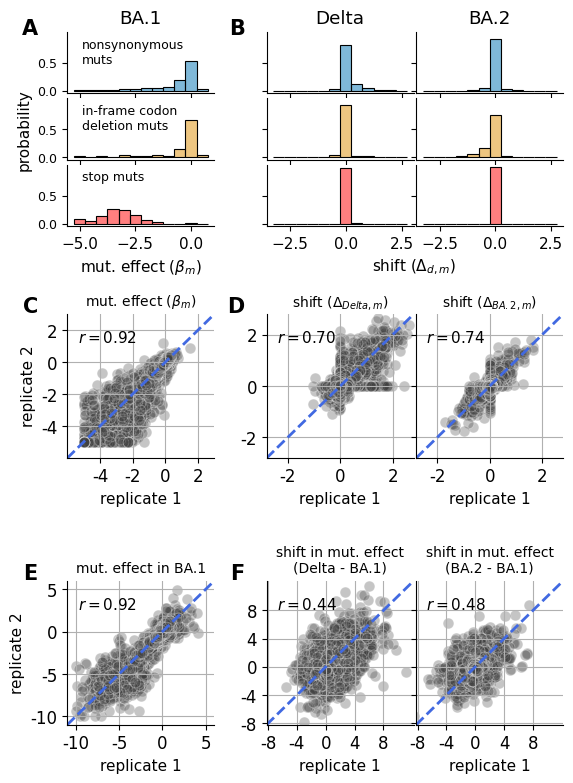

In [121]:
# data = mut_df_replicates.copy()
saveas="shift_distribution_correlation_naive"
pal = sns.color_palette('colorblind')
fig = plt.figure(figsize=[6.4, 9])

# the ratio of plot to divider between 
dist_sf = 3

# three rows of distributions
dist_rows = [[] for _ in range(3)]
for row, mut_type in enumerate(["m", "i", "n"]):
    dist_rows[row].extend([f"dist_{mut_type}_beta"]*dist_sf)
    dist_rows[row].append(".")
    for param in ["shift_Delta", "shift_Omicron_BA2"]:
        dist_rows[row].extend([f"dist_{mut_type}_{param}"]*dist_sf)

# empty space row
number_of_rows = len(dist_rows[0])
empty_row = ["."] * len(dist_rows[0])

# correlation plot row
corr_row = ["corr_beta"]*dist_sf+ ["."]
for param in ["shift_Delta", "shift_Omicron_BA2"]:
    corr_row.extend([f"corr_{param}"]*dist_sf)
    
# niave correlation plot row
naive_corr_row = ["naive_corr_Omicron_BA1_beta"]*dist_sf+ ["."]
for param in ["Delta_S", "Omicron_BA2_S"]:
    naive_corr_row.extend([f"naive_corr_{param}"]*dist_sf)

axs = fig.subplot_mosaic(
    dist_rows+[empty_row, corr_row, empty_row, naive_corr_row],
    height_ratios=[0.3, 0.3, 0.3] + [0.38, 0.7, 0.55, 0.7],
    empty_sentinel=".",
    gridspec_kw={
        "wspace": 0.05,
        "hspace": 0.05,
    }
)

query_dict = {
    "m" : "muts != '*' and muts != '-'",
    "i" : "muts == '-'",
    "n" : "muts == '*'"
}

bins_dict = {
    "beta" : np.arange(-5.25, 1.0, 0.5),
    "shift_Delta" : np.arange(-3.25, 3.25, 0.5),
    "shift_Omicron_BA2" : np.arange(-3.25, 3.25, 0.5)
}

#################
# DISTRIBUTIONS
#################
chosen_replicate_models = models.query("scale_coeff_lasso_shift == @chosen_lasso_strength")
df = multidms.utils.combine_replicate_muts(
    {
        row.replicate:row[model_name] for idx, row in chosen_replicate_models.iterrows()
    },
    times_seen_threshold=times_seen_threshold,
    how="inner"
)
df["sense"] = ["stop" if mut == "*" else "nonsynonymous" for mut in df.muts]

prefix = "avg"
bins = np.arange(-5.25, 1.0, 0.5)
# df = mut_df_replicates.copy()
df["avg_beta"].clip(lower=-5, inplace=True)

for col, param in enumerate(["beta", "shift_Delta", "shift_Omicron_BA2"]):
    for row, mut_type in enumerate(["m", "i", "n"]):
        
        iter_ax = axs[f"dist_{mut_type}_{param}"]
        sns.histplot(
            df.query(query_dict[mut_type]), 
            x=f"{prefix}_{param}", 
            ax=iter_ax,
            stat='probability',
            bins=bins_dict[param],
            label="stop",
            color="red" if mut_type == "n" else pal.as_hex()[row],
#             color="lightgrey",
            alpha=0.5
        )
        iter_ax.set_ylim(-0.05,1.05)
        
        # remove the ylabel from all but the first column
        if col != 0: 
            iter_ax.tick_params(axis='y', labelleft=False)
        iter_ax.set_yticks(
            [0.0, 0.5], [0.0, 0.5], rotation=0, ha="right",size=9
        )
#         else:
#             iter_ax.set_yticks(
#                 [0.0, 0.5], [0.0, 0.5], rotation=45, ha="right",size=9
#             )
            
        if col != 0 or row != 1:
            iter_ax.set_ylabel(None)
        else:
            iter_ax.set_ylabel("probability")
        
        # remove the x labels from all but bottom
        if row != 2:
            iter_ax.tick_params(axis='x', labelbottom=False)
            iter_ax.set_xlabel(None)

        iter_ax.set_xlabel(None)
        
        sns.despine(ax=iter_ax)
        
# axs[].set_title("")
axs["dist_n_beta"].set_xlabel(r"mut. effect $(\beta_{m})$")
axs["dist_n_beta"].xaxis.set_label_coords(0.5, -.5)


axs["dist_m_beta"].text(
    0.1, 0.9, 
    f"nonsynonymous\nmuts", 
    ha="left", va="top", 
    size=9,
    transform=axs["dist_m_beta"].transAxes
)
axs["dist_i_beta"].text(
    0.1, 0.9, 
    f"in-frame codon\ndeletion muts", 
    ha="left", va="top", 
    size=9,
    transform=axs["dist_i_beta"].transAxes
)
axs["dist_n_beta"].text(
    0.1, 0.9, 
    f"stop muts", 
    ha="left", va="top", 
    size=9,
    transform=axs["dist_n_beta"].transAxes
)

axs["dist_n_shift_Delta"].set_xlabel('shift ($\Delta_{d,m}$)')
axs["dist_n_shift_Delta"].xaxis.set_label_coords(1.0, -.5)

axs["dist_m_shift_Delta"].set_title("Delta")
axs["dist_m_shift_Omicron_BA2"].set_title("BA.2")


#################
# CORRELATIONS
#################

data = df.dropna().copy()
data['0_beta'].clip(lower=-5, inplace=True)
data['1_beta'].clip(lower=-5, inplace=True)
# plot the correlations of parameters
for col, param in enumerate(["beta", "shift_Delta", "shift_Omicron_BA2"]):
    iter_ax = axs[f"corr_{param}"]
    x, y = data[f"0_{param}"], data[f"1_{param}"]
    sns.scatterplot(
        data = data,
        x = f"0_{param}",
        y = f"1_{param}",
        ax=iter_ax,
        s=60, 
        alpha=0.3,     
        c='0.25'
    )
    
    # remove y labels from all but first column
    if col != 0: 
        
        if col == 2:
            iter_ax.tick_params(axis='y', labelleft=False)
        iter_ax.set_ylabel(None)
        
        lim = [-2.8, 2.8]
        ticks = [-2, 0, 2]
        
        iter_ax.set_ylim(lim)
        iter_ax.set_xlim(lim)
        iter_ax.set_yticks(
            ticks, ticks, size=12
        )        
        iter_ax.set_xticks(
            ticks, ticks, rotation=0, size=12
        )
            # line of equivilence
        iter_ax.plot(
            lim, 
            lim,
            linestyle="--", 
            lw=2,
            c='royalblue'
        )
        
    else:
        lim = [-6, 3]
        ticks = [-4, -2, 0, 2]
        
        iter_ax.set_ylim(lim)
        iter_ax.set_xlim(lim)
        iter_ax.set_yticks(
            ticks, ticks, size=12
        )        
        iter_ax.set_xticks(
            ticks, ticks, rotation=0, size=12
        )
            # line of equivilence
        iter_ax.plot(
            lim, 
            lim,
            linestyle="--", 
            lw=2,
            c='royalblue'
        )
        
        iter_ax.set_ylabel("replicate 2")
        
    iter_ax.set_xlabel("replicate 1")
    iter_ax.grid()

    
    corr = pearsonr(x, y)[0]
    iter_ax.annotate(
        f"$r = {corr:.2f}$", 
        (0.07, 0.8), 
        xycoords="axes fraction", 
        fontsize=11
    )
    sns.despine(ax=iter_ax)
    
#################
# NAIVE CORRELATIONS
#################

# data = mut_df_replicates.dropna().copy()
# data['0_beta'].clip(lower=-5, inplace=True)
# data['1_beta'].clip(lower=-5, inplace=True)

data = naive_mut_df.dropna().copy()
data["0-Omicron_BA1_beta"].clip(lower=-10, inplace=True)
data["1-Omicron_BA1_beta"].clip(lower=-10, inplace=True)

# plot the correlations of parameters
for col, param in enumerate(["Omicron_BA1_beta", "Delta_S", "Omicron_BA2_S"]):
    iter_ax = axs[f"naive_corr_{param}"]
    x, y = data[f"0-{param}"], data[f"1-{param}"]
    sns.scatterplot(
        data = data,
        x = f"0-{param}",
        y = f"1-{param}",
        ax=iter_ax,
        s=60, 
        alpha=0.3,     
        c='0.25'
    )
    
    # remove y labels from all but first column
    if col != 0: 
        
        if col == 2:
            iter_ax.tick_params(axis='y', labelleft=False)
        iter_ax.set_ylabel(None)
        
        lim = [-8.2, 12.2]
        ticks = range(-8, 12, 4)
        
        iter_ax.set_ylim(lim)
        iter_ax.set_xlim(lim)
        iter_ax.set_yticks(
            ticks, ticks, size=12
        )        
        iter_ax.set_xticks(
            ticks, ticks, rotation=0, size=12
        )
            # line of equivilence
        iter_ax.plot(
            lim, 
            lim,
            linestyle="--", 
            lw=2,
            c='royalblue'
        )
        
    else:
        lim = [-11, 6]
        ticks = range(-10, 6, 5)
        
        iter_ax.set_ylim(lim)
        iter_ax.set_xlim(lim)
        iter_ax.set_yticks(
            ticks, ticks, size=12
        )        
        iter_ax.set_xticks(
            ticks, ticks, rotation=0, size=12
        )
            # line of equivilence
        iter_ax.plot(
            lim, 
            lim,
            linestyle="--", 
            lw=2,
            c='royalblue'
        )
        
        iter_ax.set_ylabel("replicate 2")
        
    iter_ax.set_xlabel("replicate 1")
    iter_ax.grid()

    
    corr = pearsonr(x, y)[0]
    iter_ax.annotate(
        f"$r = {corr:.2f}$", 
        (0.07, 0.8), 
        xycoords="axes fraction", 
        fontsize=11
    )
    sns.despine(ax=iter_ax)




# Add subpanel labels
axs["dist_m_beta"].text(
    -0.2, 1.05, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["dist_m_beta"].transAxes
)


axs["dist_m_shift_Delta"].text(
    -0.15, 1.05, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["dist_m_shift_Delta"].transAxes
)

axs["corr_beta"].text(
    -0.2, 1.05, 
    f"C", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["corr_beta"].transAxes
)

axs["corr_shift_Delta"].text(
    -0.15, 1.05, 
    f"D", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["corr_shift_Delta"].transAxes
)

axs["naive_corr_Omicron_BA1_beta"].text(
    -0.2, 1.05, 
    f"E", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["naive_corr_Omicron_BA1_beta"].transAxes
)

axs["naive_corr_Delta_S"].text(
    -0.15, 1.05, 
    f"F", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["naive_corr_Delta_S"].transAxes
)



# titles
axs["dist_m_beta"].set_title("BA.1")
axs["corr_beta"].set_title(r"mut. effect $(\beta_{m})$", size=10)
axs["corr_shift_Delta"].set_title("shift ($\Delta_{Delta, m}$)", size=10)
axs["corr_shift_Omicron_BA2"].set_title("shift ($\Delta_{BA.2, m}$)", size=10)

# axs["naive_corr_Omicron_BA1_beta"].set_title(r"$\beta_{m}^{BA.1}$")
axs["naive_corr_Omicron_BA1_beta"].set_title("mut. effect in BA.1", size=10)
# axs["naive_corr_Delta_S"].set_title(r"$\beta_{m}^{Delta} - \beta_{m}^{BA.1}$")
axs["naive_corr_Delta_S"].set_title("shift in mut. effect\n(Delta - BA.1)", size=10)
axs["naive_corr_Omicron_BA2_S"].set_title("shift in mut. effect\n(BA.2 - BA.1)", size=10)
# axs["naive_corr_Omicron_BA2_S"].set_title(r"$\beta_{m}^{BA.2} - \beta_{m}^{BA.1}$")

fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')

plt.show()  

## Validation mutations

Next, we compare the results of the model to mutations tested individually in _in-vitro_

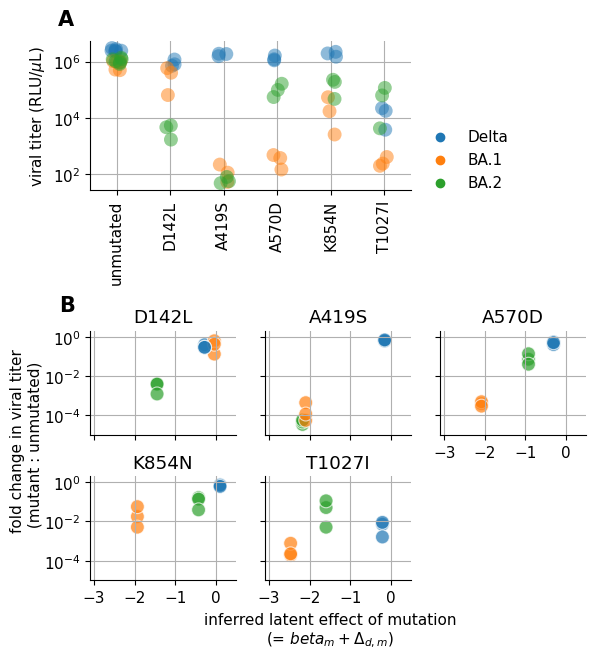

In [124]:
saveas="validation_titer_fold_change"

row1 = ['titer', 'titer', '.']
row2 = ['D142L', 'A419S', 'A570D'] 
row3 = ['K854N', 'T1027I', 'legend']
empty_row = ["."] * 3

fig = plt.figure( figsize=[6.4, 7])
axs = fig.subplot_mosaic(
    [row1, empty_row, row2, row3],
    height_ratios=[
        1, 0.39, 0.7, 0.7
    ],
    empty_sentinel=".",
    # set the width ratios between the columns
#     width_ratios=width_ratios,
    gridspec_kw={
        "wspace": 0.20,
        "hspace": 0.4,
    }
)


#############
# TITERS
#############

# Read in data
titers_df = pd.read_csv('data/viral_titers.csv')
titers_df.rename(
    columns={'RLUperuL':'titer', 'background':'homolog'},
    inplace=True
)

# Add a column giving the replicate and mutation
titers_df['replicate'] = titers_df['virus'].apply(lambda x: x[-1])
titers_df['mutation'] = titers_df['virus'].str.extract(r'_(\S+)_')
titers_df['mutation'].fillna('unmutated', inplace=True)
titers_df['mutation'].replace('142L', 'D142L', inplace=True)

# Plot data for a given mutation
validation_mutations = ['D142L', 'A419S', 'A570D', 'K854N', 'T1027I']
#mutation = 'A570D'
homologs = ['Delta', 'BA.1', 'BA.2']
replicates = ['1', '2', '3']
# plt.figure(figsize=[7,4])
xticklabels = ['unmutated'] + validation_mutations
pal = sns.color_palette('colorblind')
hex_codes = pal.as_hex()
for (i, homolog) in enumerate(homologs):
    
    data = titers_df[(titers_df['homolog'] == homolog)]
    
    sns.stripplot(
        x='mutation', y='titer', data=data, ax=axs['titer'],
        order=xticklabels, s=10, alpha=0.5,
        hue='homolog', hue_order=['Delta', 'BA.1', 'BA.2'],
    )
    sns.boxplot(
        x='mutation', y='titer', data=data, ax=axs['titer'],
        order=xticklabels,
        showfliers=False, showbox=False, showcaps=False,
        medianprops={'visible': False}, #dict(color=hex_codes[i]),
        whiskerprops={'visible': False},
    )

handles, labels = axs['titer'].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs['titer'].legend(by_label.values(), by_label.keys(), bbox_to_anchor=[1,0.5])

axs['titer'].set_yscale('log')
axs['titer'].set_yticks([1e2, 1e4, 1e6])
axs['titer'].set_xticklabels(axs['titer'].get_xticklabels(), rotation = 90)
axs['titer'].set_ylabel(r'viral titer (RLU/$\mu$L)')
axs['titer'].set_xlabel('')
axs['titer'].grid()
sns.despine(ax = axs['titer'])


#############
# FOLD CHANGE
#############

replicate_models = models.query("scale_coeff_lasso_shift == 5e-5")
fit_dict = {row.replicate:row[model_name] for _, row in replicate_models.iterrows()}
mut_df = multidms.utils.combine_replicate_muts(fit_dict, times_seen_threshold=3, how="inner")

rep0 = fit_dict[0]
for homolog in rep0.data.conditions:
    if homolog == rep0.data.reference:

        mut_df[f"beta_{homolog}"] = mut_df.avg_beta
    else:

        mut_df[f"beta_{homolog}"] = mut_df.avg_beta + mut_df[f"avg_shift_{homolog}"]

mut_df.reset_index(inplace=True)

# Read in data
val_df = pd.read_csv('data/spike_validation_data.csv')

# Restructure the data
val_dict = {
    key : []
    for key in [
        'mutation', 'fold_change', 'homolog', 'replicate',
        'predicted_beta'
    ]
}
validation_mutations = ['D142L', 'A419S', 'A570D', 'K854N', 'T1027I']
for i, row in val_df.iterrows():
    for mutation in validation_mutations:
        homolog = row['background'].replace('.', '')
        homolog = "Omicron_" + homolog if "BA" in homolog else homolog

        val_dict['mutation'].append(mutation)
        val_dict['fold_change'].append(row[mutation])
        val_dict['homolog'].append(homolog)
        val_dict['replicate'].append(row['replicate'])

        predicted_beta = float(mut_df[
            mut_df['mutation'] == mutation
        ][f'beta_{homolog}'].values[0])
        val_dict['predicted_beta'].append(predicted_beta)

val_df = pd.DataFrame(val_dict)
val_df['site'] = val_df['mutation'].apply(lambda x: int(x[1:-1]))
val_df['homolog'].replace('Omicron_BA1', 'BA.1', inplace=True)
val_df['homolog'].replace('Omicron_BA2', 'BA.2', inplace=True)
val_df.sort_values('site', inplace=True)

for (i, mutation) in enumerate(validation_mutations):
    data = val_df[val_df['mutation'] == mutation]
    iter_ax = axs[mutation]
    sns.scatterplot(
        x='predicted_beta', y='fold_change', data=data,
        hue='homolog', ax=iter_ax, s=100, alpha=0.7,
        hue_order=['Delta', 'BA.1', 'BA.2']
    )
    iter_ax.set(
        title=mutation, xlabel='', ylabel='',
        yscale='log', ylim=[1e-5,2], yticks=[1, 1e-2, 1e-4],
        xlim=[-3.1, 0.5], xticks=[-3, -2, -1, 0]
    )
    iter_ax.grid()
    iter_ax.get_legend().remove()
    sns.despine(ax=iter_ax)
    
    if mutation in ['D142L', 'A419S']:
        iter_ax.tick_params(axis="x", labelbottom=False)
    
    if mutation not in ['D142L', 'K854N']:
        iter_ax.tick_params(axis="y", labelleft=False)

fig.text(
    0.5, 0.02, 'inferred latent effect of mutation\n(= $beta_m + \Delta_{d,m}$)',
    ha='center'
)
fig.text(
    0.000, 0.31, 'fold change in viral titer\n (mutant : unmutated)',
    va='center', rotation='vertical'
)
axs["legend"].set_axis_off()

axs["titer"].text(
    -0.05, 1.15, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["titer"].transAxes
)
axs["D142L"].text(
    -0.1, 1.25, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["D142L"].transAxes
)

fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Model reference choice comparison

Here, we fit each of the replicate dataset as before, but we also fit models where using Delta and BA.2 as a reference to show the model is robust to choice of reference 

In [ ]:
ref_com_models = pd.DataFrame()
fit_iter = 0

for reference in ["Delta", "Omicron_BA1", "Omicron_BA2"]:
    for rep_fsdf, replicate in zip([fs_rep1, fs_rep2], [1, 2]):   
        
        start = time.time()

        # initialize data object
        data = multidms.Data(
            rep_fsdf,
            collapse_identical_variants="mean",
            alphabet=multidms.AAS_WITHSTOP_WITHGAP,
            reference=reference,
            assert_site_integrity=False,
            verbose=True,
            nb_workers=8 
        )
        data.condition_colors = cc

        end = time.time()
        prep_time = round(end-start)
        print(f"Finished, time: {prep_time}")

        fit_params = {
            'init_beta_naught' : 0.0,
            'epistatic_model' : "Sigmoid",
            'output_activation' : "Identity",
            'warmup_beta':False,
            'gamma_corrected':False,
            'alpha_d': True,
            'scale_coeff_lasso_shift':5e-05,
            'scale_coeff_ridge_beta':0,
            'scale_coeff_ridge_shift':0,
            'scale_coeff_ridge_gamma':1e-3,
            'scale_coeff_ridge_ch':1e-3,
            'tol':1e-4,
            'save_model_at':[30000],
            'num_training_steps': 30,
            'iterations_per_step':1000
        }
        
        start_t = time.time()
        model = multidms.utils.fit_wrapper(data, **fit_params)
        model['replicate'] = replicate
        model['reference'] = reference
        ref_com_models = pd.concat([ref_com_models, model], ignore_index=True)
        end_t = time.time()
        fit_iter += 1
        print(f"Done with {fit_iter}/6! Total time: {round(end_t - start_t)}")
        print("------------------------------------------")
        

    pickle.dump(ref_com_models, open(f"{OUTDIR}/ref_com_models.pkl", "wb"))

inferring site map for Delta


  0%|          | 0/28515 [00:00<?, ?it/s]

inferring site map for Omicron_BA1


  0%|          | 0/70597 [00:00<?, ?it/s]

inferring site map for Omicron_BA2


  0%|          | 0/60397 [00:00<?, ?it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [144, 143, 69, 145, 70, 211, 25, 26, 24, 157, 158, 898],
dropping: 10983 variantswhich have mutations at those sites.


invalid non-identical-sites: [371, 376], dropping 3499 variants
Converting mutations for Delta
is reference, skipping
Converting mutations for Omicron_BA1


Converting mutations for Omicron_BA2


Finished, time: 86
running:
{'PRNGKey': 0,
 'alpha_d': True,
 'data_idx': 0,
 'dataset': <multidms.data.Data object at 0x7f850fdd5c10>,
 'epistatic_model': 'Sigmoid',
 'gamma_corrected': False,
 'huber_scale_huber': 1,
 'init_beta_naught': 0.0,
 'iterations_per_step': 1000,
 'lock_beta': False,
 'lock_beta_naught': None,
 'num_training_steps': 30,
 'output_activation': 'Identity',
 'save_model_at': [30000],
 'scale_coeff_lasso_shift': 5e-05,
 'scale_coeff_ridge_beta': 0,
 'scale_coeff_ridge_ch': 0.001,
 'scale_coeff_ridge_gamma': 0.001,
 'scale_coeff_ridge_shift': 0,
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 0.0001,
 'warmup_beta': False}
training_step 0/30,Loss: 1.2605234291784324, Time: 27 Seconds
training_step 1/30,Loss: 0.999524635155407, Time: 22 Seconds
training_step 2/30,Loss: 0.9030574688633981, Time: 22 Seconds
training_step 3/30,Loss: 0.8688729049594187, Time: 2

  0%|          | 0/29158 [00:00<?, ?it/s]

inferring site map for Omicron_BA1


  0%|          | 0/62129 [00:00<?, ?it/s]

inferring site map for Omicron_BA2


  0%|          | 0/57719 [00:00<?, ?it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [145, 70, 144, 143, 69, 211, 422, 26, 24, 25, 157, 158],
dropping: 10129 variantswhich have mutations at those sites.


invalid non-identical-sites: [371], dropping 1873 variants
Converting mutations for Delta
is reference, skipping
Converting mutations for Omicron_BA1


Converting mutations for Omicron_BA2


Finished, time: 84
running:
{'PRNGKey': 0,
 'alpha_d': True,
 'data_idx': 0,
 'dataset': <multidms.data.Data object at 0x7f84bf2f7390>,
 'epistatic_model': 'Sigmoid',
 'gamma_corrected': False,
 'huber_scale_huber': 1,
 'init_beta_naught': 0.0,
 'iterations_per_step': 1000,
 'lock_beta': False,
 'lock_beta_naught': None,
 'num_training_steps': 30,
 'output_activation': 'Identity',
 'save_model_at': [30000],
 'scale_coeff_lasso_shift': 5e-05,
 'scale_coeff_ridge_beta': 0,
 'scale_coeff_ridge_ch': 0.001,
 'scale_coeff_ridge_gamma': 0.001,
 'scale_coeff_ridge_shift': 0,
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 0.0001,
 'warmup_beta': False}
training_step 0/30,Loss: 1.205205251603795, Time: 26 Seconds
training_step 1/30,Loss: 0.9783868394403228, Time: 22 Seconds
training_step 2/30,Loss: 0.9058261938758438, Time: 21 Seconds
training_step 3/30,Loss: 0.8655712236131738, Time: 2

  0%|          | 0/28515 [00:00<?, ?it/s]

inferring site map for Omicron_BA1


  0%|          | 0/70597 [00:00<?, ?it/s]

inferring site map for Omicron_BA2


  0%|          | 0/60397 [00:00<?, ?it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [144, 143, 69, 145, 70, 211, 25, 26, 24, 157, 158, 898],
dropping: 10983 variantswhich have mutations at those sites.


invalid non-identical-sites: [371], dropping 2041 variants
Converting mutations for Delta


Converting mutations for Omicron_BA1
is reference, skipping
Converting mutations for Omicron_BA2


Finished, time: 81
running:
{'PRNGKey': 0,
 'alpha_d': True,
 'data_idx': 0,
 'dataset': <multidms.data.Data object at 0x7f8518a43890>,
 'epistatic_model': 'Sigmoid',
 'gamma_corrected': False,
 'huber_scale_huber': 1,
 'init_beta_naught': 0.0,
 'iterations_per_step': 1000,
 'lock_beta': False,
 'lock_beta_naught': None,
 'num_training_steps': 30,
 'output_activation': 'Identity',
 'save_model_at': [30000],
 'scale_coeff_lasso_shift': 5e-05,
 'scale_coeff_ridge_beta': 0,
 'scale_coeff_ridge_ch': 0.001,
 'scale_coeff_ridge_gamma': 0.001,
 'scale_coeff_ridge_shift': 0,
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 0.0001,
 'warmup_beta': False}
training_step 0/30,Loss: 1.0301489074136183, Time: 20 Seconds
training_step 1/30,Loss: 0.8815023085296904, Time: 17 Seconds
training_step 2/30,Loss: 0.8316761322453992, Time: 17 Seconds
training_step 3/30,Loss: 0.8057918973855474, Time: 

  0%|          | 0/29158 [00:00<?, ?it/s]

inferring site map for Omicron_BA1


  0%|          | 0/62129 [00:00<?, ?it/s]

inferring site map for Omicron_BA2


  0%|          | 0/57719 [00:00<?, ?it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [145, 70, 144, 143, 69, 211, 422, 26, 24, 25, 157, 158],
dropping: 10129 variantswhich have mutations at those sites.


invalid non-identical-sites: [371], dropping 1873 variants
Converting mutations for Delta


Converting mutations for Omicron_BA1
is reference, skipping
Converting mutations for Omicron_BA2


Finished, time: 82
running:
{'PRNGKey': 0,
 'alpha_d': True,
 'data_idx': 0,
 'dataset': <multidms.data.Data object at 0x7f85131ac5d0>,
 'epistatic_model': 'Sigmoid',
 'gamma_corrected': False,
 'huber_scale_huber': 1,
 'init_beta_naught': 0.0,
 'iterations_per_step': 1000,
 'lock_beta': False,
 'lock_beta_naught': None,
 'num_training_steps': 30,
 'output_activation': 'Identity',
 'save_model_at': [30000],
 'scale_coeff_lasso_shift': 5e-05,
 'scale_coeff_ridge_beta': 0,
 'scale_coeff_ridge_ch': 0.001,
 'scale_coeff_ridge_gamma': 0.001,
 'scale_coeff_ridge_shift': 0,
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 0.0001,
 'warmup_beta': False}
training_step 0/30,Loss: 1.0488032402947918, Time: 20 Seconds
training_step 1/30,Loss: 0.8753462512325968, Time: 17 Seconds
training_step 2/30,Loss: 0.8108047806996399, Time: 17 Seconds
training_step 3/30,Loss: 0.7859567618338887, Time: 

In [125]:
ref_com_models = pickle.load(open(f"{OUTDIR}/ref_com_models.pkl", "rb"))

For each of the reference fits, compute parameters relative to a BA.1 reference

In [126]:
relative_params = pd.DataFrame()
homologs = ["Delta", "Omicron_BA1", "Omicron_BA2"]

# For each respective model fit 
for reference, replicate_models in ref_com_models.groupby("reference"):
    
    # combine the replicate mutational 
    mut_df = multidms.utils.combine_replicate_muts(
        {
            f"rep_{row.replicate}":row["model_30000"] 
            for idx, row in replicate_models.iterrows()
        },
        times_seen_threshold = 1
    )
    
    mut_df = mut_df.copy()[[c for c in mut_df.columns if "avg" in c]]
    
    # Compute mut effect (beta+shift) relative to each homolog
    for homolog in homologs:
        if homolog == reference:
            mut_df[f"beta_{homolog}"] = mut_df["avg_beta"]
        else:
            mut_df[f"beta_{homolog}"] = mut_df["avg_beta"] + mut_df[f"avg_shift_{homolog}"]
       
    # Compute shifts relative to BA1 (betas_h - beta_BA1)
    for homolog in homologs:
        mut_df[f"shift_{homolog}"] = mut_df[f"beta_{homolog}"] - mut_df[f"beta_Omicron_BA1"]
    
    # drop un-neccessary columns
    mut_df.drop([c for c in mut_df.columns if "avg" in c], axis=1, inplace=True)
    
    mut_df = mut_df.assign(reference = reference)
    
    relative_params = pd.concat([relative_params, mut_df])

    
relative_params.drop(["beta_Delta", "beta_Omicron_BA2", "shift_Omicron_BA1"], axis=1, inplace=True)
relative_params.reference.replace({"Omicron_BA2":"BA2", "Omicron_BA1": "BA1"}, inplace=True)
relative_params

beta_Omicron_BA1  shift_Delta  shift_Omicron_BA2 reference
mutation                                                            
M1I              -3.807655     0.000000           0.000000     Delta
F2L               0.225899     0.000000          -0.003043     Delta
F2S               0.161098     0.000000           0.000000     Delta
F2V               0.468743     0.000000           0.000000     Delta
V3A              -0.066108    -0.011762          -0.011762     Delta
...                    ...          ...                ...       ...
S1252T           -0.151533    -0.034652          -0.034652       BA2
S1252V            0.155869     0.033387          -0.062213       BA2
S1252W            0.176853     0.000000           0.000000       BA2
S1252Y            0.399715    -0.157242          -0.102541       BA2
S1252*           -0.060105     0.106457           0.056037       BA2

[17804 rows x 4 columns]

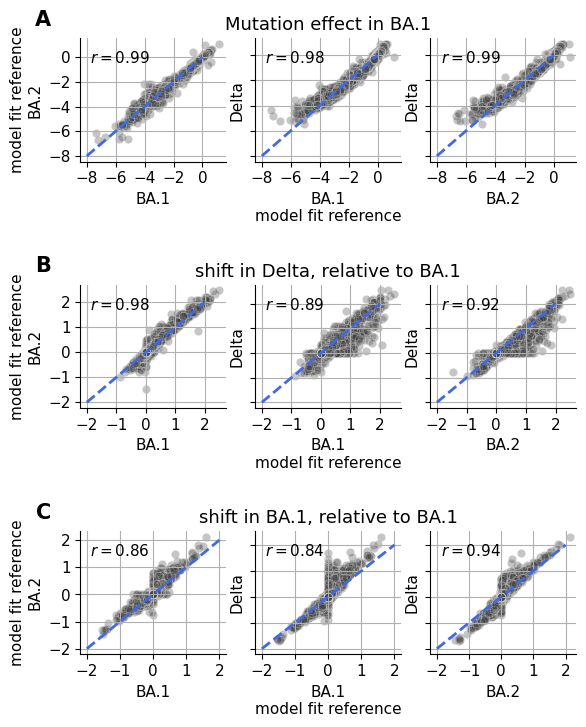

In [127]:
saveas = "reference_model_comparison_params_scatter"
parameters = ["beta_Omicron_BA1", "shift_Delta", "shift_Omicron_BA2"]


fig = plt.figure( figsize=[6.4, 8])
axs = fig.subplot_mosaic(
    [[f"{param}_{col}" for col in range(3)] for param in parameters],
    gridspec_kw={
        "wspace": 0.20,
        "hspace": 1.0,
    }
)

param_limits = {
    "beta_Omicron_BA1" : range(-8, 2, 2),
    "shift_Delta" : range(-2, 3),
    "shift_Omicron_BA2" : range(-2, 3) 
}

param_titles = {
    "beta_Omicron_BA1" : r"Mutation effect in BA.1",
    "shift_Delta" : "shift in Delta, relative to BA.1",
    "shift_Omicron_BA2" : "shift in BA.1, relative to BA.1"
}


for row, param in enumerate(parameters):
    
    # pivot to each fit on columns, drop NIS.
    data = relative_params.pivot(
        columns = "reference",
        values = param
    ).dropna()

    # plot each combination of fits
    for col, (x, y) in enumerate(combinations(data.columns, 2)):
        iter_ax = axs[f"{param}_{col}"]
        
        sns.scatterplot(
            data = data,
            x = x,
            y = y,
            ax = iter_ax,
            alpha=0.3,
            c='0.25'
        )
        
        corr = pearsonr(data[x], data[y])[0]
        iter_ax.annotate(
            f"$r = {corr:.2f}$", 
            (0.07, 0.8), 
            xycoords="axes fraction", 
            fontsize=11
        )
        
        limits = param_limits[param]
        iter_ax.set_yticks(limits)
        iter_ax.set_xticks(limits)
        mmin, mmax = min(limits), max(limits)
        iter_ax.plot([mmin, mmax], [mmin, mmax], "--", lw=2, c="royalblue")
        label_fn = lambda x: x if x == "Delta" else f"{x[0]}{x[1]}.{x[2]}"
        
        
        xl = f"{label_fn(x)}"
        yl = f"{label_fn(y)}"
        if col == 1: xl += "\nmodel fit reference"
        if col == 0: yl = "model fit reference\n" + yl
        iter_ax.set_xlabel(xl)
        iter_ax.set_ylabel(yl)            
            
        
        
        iter_ax.grid()
        sns.despine(ax = iter_ax)
        
        if col != 0:
            iter_ax.tick_params("y", labelleft=False)
            
        if col == 1:
            iter_ax.set_title(param_titles[param], size=13)
            


for param, sub_anno in zip(parameters, ["A", "B", "C"]):
    iter_ax = axs[f"{param}_0"]    
    axs[f"{param}_0"].text(
        -0.2, 1.15, 
        sub_anno, 
        ha="right", va="center", 
        size=15,
        weight="bold",
        transform=iter_ax.transAxes
    )

fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Cumulative distribution of model sparsity

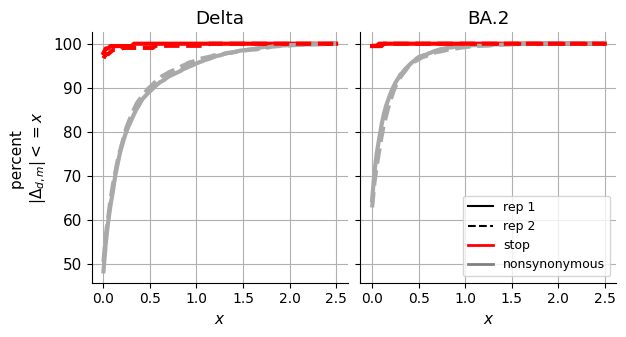

In [128]:
saveas = "percent_shifts_under_x_lineplot"
fig, ax = plt.subplots(1,2, figsize=[6.4,3.5], sharey='row')
tall_mut_df_chosen = tall_mut_df.query("scale_coeff_lasso == '5e-05' & condition != 'Omicron_BA1'")

condition_col = {
    "Delta" : 0,
    "Omicron_BA2" : 1
}

replicate_line_style = {
    0 : "-",
    1 : "--"
}

sense_colors = {
    "nonsynonymous" : "darkgrey",
    "stop" : "red"
}

t_points = np.linspace(0, 2.5, 100)
def perc_abs_lte(x, t):
    abs_x = np.abs(x)
    return len(abs_x[abs_x<=t]) / len(x) #)*100

for (condition, replicate, sense), df in tall_mut_df_chosen.groupby(["condition", "replicate", "sense"]):
    iter_ax = ax[condition_col[condition]]
    lt_percentages = [perc_abs_lte(df["S"], t)*100 for t in t_points]
    iter_ax.plot(
        t_points, 
        lt_percentages,
        linestyle = replicate_line_style[replicate],
        color = sense_colors[sense],
        linewidth = 3
    )
    iter_ax.set_xticks(np.linspace(0,2.5,6),np.linspace(0,2.5,6), rotation=0, ha="center",size=10)
    sns.despine(ax=iter_ax)
    iter_ax.grid(visible=True)
    
ax[condition_col["Delta"]].set_title("Delta")
ax[condition_col["Omicron_BA2"]].set_title("BA.2")

ax[0].set_ylabel("percent \n$|\Delta_{d,m}| <= x$")
ax[0].set_xlabel("$x$")
ax[1].set_xlabel("$x$")

black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
red_line = mlines.Line2D([], [], color='red', linewidth=2,linestyle='-',markersize=5, label='stop')
grey_line = mlines.Line2D([], [], color='grey',linewidth=2, linestyle='-',markersize=5, label='nonsynonymous')
ax[1].legend(
    handles=[black_line, black_dashed, red_line, grey_line], 
    bbox_to_anchor = (1, 0), 
    loc='lower right', 
    frameon=True, 
    fontsize=9
)

plt.tight_layout()
fig.subplots_adjust(wspace=0.05)
fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Correlation of BA2 and Delta Shifts

In [129]:
chosen_replicate_models = models.query("scale_coeff_lasso_shift == @chosen_lasso_strength")
mut_df_replicates = multidms.utils.combine_replicate_muts(
    {
        row.replicate:row[model_name] for idx, row in chosen_replicate_models.iterrows()
    },
    times_seen_threshold=times_seen_threshold,
    how="inner"
)
mut_df_replicates["sense"] = [
    "stop" if mut == "*" else "nonsynonymous" for mut in mut_df_replicates.muts
]

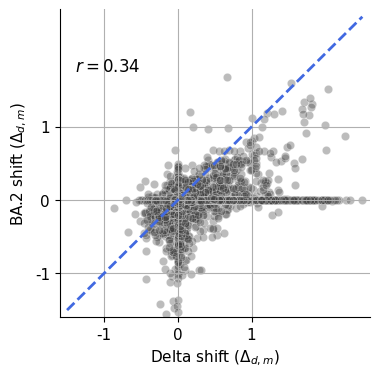

In [130]:
data = mut_df_replicates.dropna()
saveas="shift_corr_Delta_BA2"
fig, ax = plt.subplots(1,figsize=[4,4])
lim = [-1.6, 2.6]
ticks = range(-1, 2)
sns.scatterplot(
    data=data,
    x="avg_shift_Delta",
    y="avg_shift_Omicron_BA2",
#     hue = "sense",
    alpha = 0.35,
    ax=ax,
    c='0.25'
)
ax.plot()
ax.plot(
    [-1.5, 2.5], 
    [-1.5, 2.5],
    linestyle="--", 
    lw=2,
    c='royalblue'
)
corr = pearsonr(data["avg_shift_Delta"], data["avg_shift_Omicron_BA2"])[0]
ax.annotate(
    f"$r = {corr:.2f}$", 
    (0.05, 0.8), 
    xycoords="axes fraction", 
    fontsize=12
)
ax.set_ylim(lim)
ax.set_xlim(lim)
ax.set_yticks(ticks, labels=ticks)
ax.set_xticks(ticks, labels=ticks)
ax.set_ylabel("BA.2 shift ($\Delta_{d,m}$)")
ax.set_xlabel("Delta shift ($\Delta_{d,m}$)")
# ax.set(xticks=np.linspace(-1.5, 2.5, 5))
ax.grid()
sns.despine(ax=ax)

fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()